In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "MI_450_20k_fully"
    npy_file_name_aniso = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_dat = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.dat"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    npy_file_name_aniso_energy_dat = f"p_ori_fully5d_fz_aveE_f1.0_t1.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.dat"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    # npy_file_aniso.tofile(npy_file_folder + npy_file_name_aniso_dat)
    # npy_file_aniso = np.memmap(npy_file_folder + npy_file_name_aniso_dat, dtype='int64', mode='r',shape=(56,450,450,450))
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    # npy_file_aniso_energy.tofile(npy_file_folder + npy_file_name_aniso_energy_dat)
    # npy_file_aniso_energy = np.memmap(npy_file_folder + npy_file_name_aniso_energy_dat, dtype='float64', mode='r',shape=(56,450,450,450))
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso_energy.shape

The MI_450_20k_fully data size is: (56, 450, 450, 450)
READING DATA DONE
The MI_450_20k_fully energy data size is: (56, 450, 450, 450)
READING ENERGY DATA DONE


In [3]:
step_1000grains = 42
len(np.unique(npy_file_aniso[42,:]))

1012

In [4]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    from collections import defaultdict
    step_num=51
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/3D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/3D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"].item()
            GB_infomation_dict_list.append(GB_infomation_dict)
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"].item()
                curvature_matrix_list.append(curvature_matrix)
            else:
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Create shifted arrays for all 6 directions at once
            neighbors = np.stack([
                np.roll(current_microstructure, -1, axis=0),
                np.roll(current_microstructure, 1, axis=0),
                np.roll(current_microstructure, -1, axis=1),
                np.roll(current_microstructure, 1, axis=1),
                np.roll(current_microstructure, -1, axis=2),
                np.roll(current_microstructure, 1, axis=2)
            ])
            neighbor_array = neighbors.reshape(6, -1).T
            
            # Find boundary voxels efficiently
            boundary_mask = (neighbors != current_microstructure[None,...]).any(axis=0)
            boundary_coords = np.argwhere(boundary_mask)
            
            GB_infomation_dict = defaultdict(list)
            gb_points_by_pair = defaultdict(list)
            pair_id_pair_dict = defaultdict(list)
            
            for idx, (i, j, k) in enumerate(boundary_coords):
                flat_idx = i * size_y * size_z + j * size_z + k
                neighbor_vals = neighbor_array[flat_idx]
                central_site = current_microstructure[i,j,k]
                unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
                
                if len(unique_neighbors) == 1:  # Single boundary point
                    neighbor = unique_neighbors[0]
                    pair_id = post_processing.get_line(central_site, neighbor)
                    pair_id_pair = sorted([central_site, neighbor])
                        
                    # Collect points for batch processing
                    gb_points_by_pair[pair_id].append([i,j,k])
                    if pair_id not in pair_id_pair_dict:
                        pair_id_pair_dict[pair_id].append(pair_id_pair)
            print("completed GB voxel collection")
            
            # Process each pair_id's points in batch
            for pair_id, points in gb_points_by_pair.items():
                # calculate or extract curvature
                if pair_id not in curvature_matrix: continue
                pair_id_pair = pair_id_pair_dict[pair_id][0]
                
                area = len(points)
                pos_ave = np.sum(points, axis=0) / area
                
                GB_infomation_dict[pair_id] = np.array([area, pos_ave[0],pos_ave[1],pos_ave[2],-curvature_matrix[pair_id][3],area,pair_id_pair[0],pair_id_pair[1]])
            print("Completed GB information collection")    
            
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            

100%|██████████| 51/51 [00:07<00:00,  7.07it/s]


In [5]:
    # GB Energy information
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:08<00:00,  6.17it/s]


In [6]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -1e-4 # not large difference, no GB in [-1e-4,0]
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(0,step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < 100 or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 140856
key num end with 50413


100%|██████████| 50413/50413 [00:00<00:00, 283355.40it/s]


finish 0 with num of GBs 50413, and collected num of GBs 29992
key num start with 141475
key num end with 73276


100%|██████████| 73276/73276 [00:00<00:00, 549947.16it/s]


finish 1 with num of GBs 73276, and collected num of GBs 49459
key num start with 131269
key num end with 68841


100%|██████████| 68841/68841 [00:00<00:00, 549785.28it/s]


finish 2 with num of GBs 68841, and collected num of GBs 63276
key num start with 118117
key num end with 62456


100%|██████████| 62456/62456 [00:00<00:00, 542094.24it/s]


finish 3 with num of GBs 62456, and collected num of GBs 73094
key num start with 104359
key num end with 55707


100%|██████████| 55707/55707 [00:00<00:00, 542429.60it/s]


finish 4 with num of GBs 55707, and collected num of GBs 79855
key num start with 91031
key num end with 49767


100%|██████████| 49767/49767 [00:00<00:00, 530379.96it/s]


finish 5 with num of GBs 49767, and collected num of GBs 85099
key num start with 80054
key num end with 44910


100%|██████████| 44910/44910 [00:00<00:00, 502575.21it/s]


finish 6 with num of GBs 44910, and collected num of GBs 89270
key num start with 70524
key num end with 40344


100%|██████████| 40344/40344 [00:00<00:00, 541463.74it/s]


finish 7 with num of GBs 40344, and collected num of GBs 92752
key num start with 62151
key num end with 36155


100%|██████████| 36155/36155 [00:00<00:00, 534260.59it/s]


finish 8 with num of GBs 36155, and collected num of GBs 95730
key num start with 54983
key num end with 32503


100%|██████████| 32503/32503 [00:00<00:00, 479728.98it/s]


finish 9 with num of GBs 32503, and collected num of GBs 98196
key num start with 48766
key num end with 29461


100%|██████████| 29461/29461 [00:00<00:00, 551359.07it/s]


finish 10 with num of GBs 29461, and collected num of GBs 100335
key num start with 43638
key num end with 26934


100%|██████████| 26934/26934 [00:00<00:00, 519922.98it/s]


finish 11 with num of GBs 26934, and collected num of GBs 102104
key num start with 39249
key num end with 24652


100%|██████████| 24652/24652 [00:00<00:00, 532984.78it/s]


finish 12 with num of GBs 24652, and collected num of GBs 103673
key num start with 35716
key num end with 22665


100%|██████████| 22665/22665 [00:00<00:00, 550536.56it/s]


finish 13 with num of GBs 22665, and collected num of GBs 105012
key num start with 32553
key num end with 20650


100%|██████████| 20650/20650 [00:00<00:00, 542816.71it/s]


finish 14 with num of GBs 20650, and collected num of GBs 106175
key num start with 29652
key num end with 18981


100%|██████████| 18981/18981 [00:00<00:00, 546249.80it/s]


finish 15 with num of GBs 18981, and collected num of GBs 107165
key num start with 27152
key num end with 17572


100%|██████████| 17572/17572 [00:00<00:00, 531337.17it/s]


finish 16 with num of GBs 17572, and collected num of GBs 108069
key num start with 24907
key num end with 16356


100%|██████████| 16356/16356 [00:00<00:00, 487881.80it/s]


finish 17 with num of GBs 16356, and collected num of GBs 108816
key num start with 23145
key num end with 15196


100%|██████████| 15196/15196 [00:00<00:00, 530899.79it/s]


finish 18 with num of GBs 15196, and collected num of GBs 109487
key num start with 21490
key num end with 14248


100%|██████████| 14248/14248 [00:00<00:00, 550772.27it/s]

finish 19 with num of GBs 14248, and collected num of GBs 110082
key num start with 20017


key num end with 13411


100%|██████████| 13411/13411 [00:00<00:00, 557077.74it/s]


finish 20 with num of GBs 13411, and collected num of GBs 110588
key num start with 18764
key num end with 12578


100%|██████████| 12578/12578 [00:00<00:00, 559116.07it/s]


finish 21 with num of GBs 12578, and collected num of GBs 111056
key num start with 17615
key num end with 11879


100%|██████████| 11879/11879 [00:00<00:00, 550512.54it/s]


finish 22 with num of GBs 11879, and collected num of GBs 111459
key num start with 16689
key num end with 11336


100%|██████████| 11336/11336 [00:00<00:00, 539805.75it/s]


finish 23 with num of GBs 11336, and collected num of GBs 111831
key num start with 15834
key num end with 10613


100%|██████████| 10613/10613 [00:00<00:00, 540377.64it/s]


finish 24 with num of GBs 10613, and collected num of GBs 112209
key num start with 14916
key num end with 10066


100%|██████████| 10066/10066 [00:00<00:00, 511948.30it/s]


finish 25 with num of GBs 10066, and collected num of GBs 112499
key num start with 14151
key num end with 9567


100%|██████████| 9567/9567 [00:00<00:00, 549314.93it/s]


finish 26 with num of GBs 9567, and collected num of GBs 112751
key num start with 13416
key num end with 9077


100%|██████████| 9077/9077 [00:00<00:00, 539136.99it/s]


finish 27 with num of GBs 9077, and collected num of GBs 112982
key num start with 12717
key num end with 8420


100%|██████████| 8420/8420 [00:00<00:00, 548624.24it/s]


finish 28 with num of GBs 8420, and collected num of GBs 113241
key num start with 12028
key num end with 8087


100%|██████████| 8087/8087 [00:00<00:00, 563219.59it/s]


finish 29 with num of GBs 8087, and collected num of GBs 113454
key num start with 11427
key num end with 7732


100%|██████████| 7732/7732 [00:00<00:00, 558787.64it/s]


finish 30 with num of GBs 7732, and collected num of GBs 113679
key num start with 10821
key num end with 7234


100%|██████████| 7234/7234 [00:00<00:00, 565157.21it/s]


finish 31 with num of GBs 7234, and collected num of GBs 113868
key num start with 10263
key num end with 6888


100%|██████████| 6888/6888 [00:00<00:00, 565712.39it/s]


finish 32 with num of GBs 6888, and collected num of GBs 114048
key num start with 9826
key num end with 6624


100%|██████████| 6624/6624 [00:00<00:00, 551514.01it/s]


finish 33 with num of GBs 6624, and collected num of GBs 114218
key num start with 9394
key num end with 6394


100%|██████████| 6394/6394 [00:00<00:00, 571662.01it/s]


finish 34 with num of GBs 6394, and collected num of GBs 114374
key num start with 9042
key num end with 6049


100%|██████████| 6049/6049 [00:00<00:00, 576071.59it/s]


finish 35 with num of GBs 6049, and collected num of GBs 114505
key num start with 8676
key num end with 5857


100%|██████████| 5857/5857 [00:00<00:00, 564840.40it/s]


finish 36 with num of GBs 5857, and collected num of GBs 114628
key num start with 8342
key num end with 5645


100%|██████████| 5645/5645 [00:00<00:00, 577624.93it/s]


finish 37 with num of GBs 5645, and collected num of GBs 114747
key num start with 7989
key num end with 5332


100%|██████████| 5332/5332 [00:00<00:00, 532679.80it/s]


finish 38 with num of GBs 5332, and collected num of GBs 114877
key num start with 7643
key num end with 5157


100%|██████████| 5157/5157 [00:00<00:00, 554076.18it/s]

finish 39 with num of GBs 5157, and collected num of GBs 114971
key num start with 7382


key num end with 4985


100%|██████████| 4985/4985 [00:00<00:00, 548695.89it/s]

finish 40 with num of GBs 4985, and collected num of GBs 115061
key num start with 7158
key num end with 4827



100%|██████████| 4827/4827 [00:00<00:00, 583539.57it/s]


finish 41 with num of GBs 4827, and collected num of GBs 115138
key num start with 6907
key num end with 4600


100%|██████████| 4600/4600 [00:00<00:00, 557785.44it/s]


finish 42 with num of GBs 4600, and collected num of GBs 115210
key num start with 6661
key num end with 4385


100%|██████████| 4385/4385 [00:00<00:00, 551137.91it/s]

finish 43 with num of GBs 4385, and collected num of GBs 115289
key num start with 6419


key num end with 4262


100%|██████████| 4262/4262 [00:00<00:00, 549206.54it/s]


finish 44 with num of GBs 4262, and collected num of GBs 115369
key num start with 6205
key num end with 4105


100%|██████████| 4105/4105 [00:00<00:00, 573118.23it/s]


finish 45 with num of GBs 4105, and collected num of GBs 115433
key num start with 5964
key num end with 3941


100%|██████████| 3941/3941 [00:00<00:00, 578631.01it/s]


finish 46 with num of GBs 3941, and collected num of GBs 115512
key num start with 5779
key num end with 3803


100%|██████████| 3803/3803 [00:00<00:00, 577409.52it/s]


finish 47 with num of GBs 3803, and collected num of GBs 115581
key num start with 5611
key num end with 3751


100%|██████████| 3751/3751 [00:00<00:00, 765699.82it/s]


finish 48 with num of GBs 3751, and collected num of GBs 115581
key num start with 5443
key num end with 3598


100%|██████████| 3598/3598 [00:00<00:00, 768034.29it/s]


finish 49 with num of GBs 3598, and collected num of GBs 115581


In [7]:
    time_interval = 2
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    for time_step in tqdm(range(3,step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 48/48 [00:04<00:00,  9.62it/s]


In [8]:
len(GB_antic_list_velocity_AllList[42])+len(GB_normc_list_velocity_AllList[42])

3652

In [9]:
    print("anti-c GB")
    total_GB_num = 0
    for time_step in range(3,step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("Over all voxels")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")


anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 188159
The ratio of anti-curvature GBs during whole simulations is 15.349693591860442% in 1225816 GBs
The ratio of norm-curvature GBs during whole simulations is 38.48538442963708% in 1225816 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 28.512438647773443% in 659919 GBs
The ratio of norm-curvature GBs during whole simulations is 71.48756135222656% in 659919 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 163887898 and 91686254
The ratio of anti-curvature voxels during whole simulations is 35.87461927683516% in 255574152 voxels

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 11155435 and 34541328
The ratio of anti-curvature voxels during whole simulations is 75.58812863834578% in 45696763 voxels
Voxels on norm-c GBs
The number of the normal voxels and an

<Figure size 432x288 with 0 Axes>

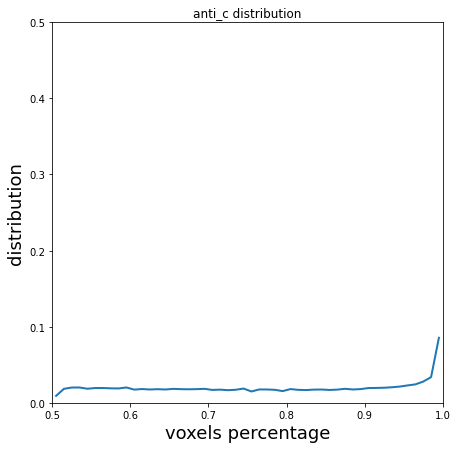

<Figure size 432x288 with 0 Axes>

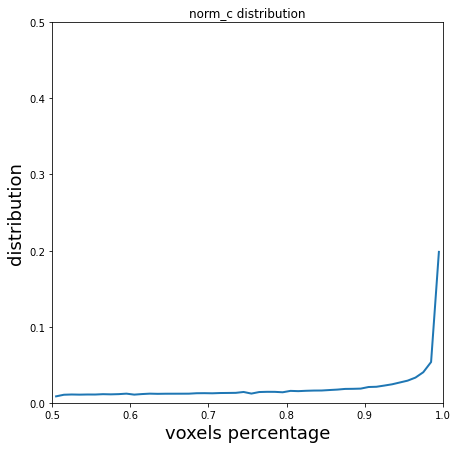

In [10]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/3D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/3D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [11]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(3,step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 8831 and 3614626
The ratio of anti-curvature voxels during whole simulations is 99.75628246726814% in 3623457 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 31255260 and 65998
The ratio of norm-curvature voxels during whole simulations is 99.78928687985649% in 31321258 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 188159
The ratio of anti-curvature and norm GBs during whole simulations is 28.512438647773443% and 71.48756135222656% in 659919 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 16076
The ratio of anti-curvature and norm GBs during whole simulations is 2.4360565463337167% and 14.177346007616087% in 659919 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (or

99.36037604615112% GBs with curvature smaller than 0.2
4.700478725478213
all points fitting: 0.640452227262436
all points slope: 0.8533471705375972
smaller points fitting: 0.9953458600288002
smaller points slope: 3.6087766738595954


<Figure size 432x288 with 0 Axes>

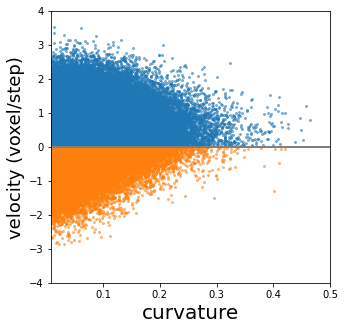

<Figure size 432x288 with 0 Axes>

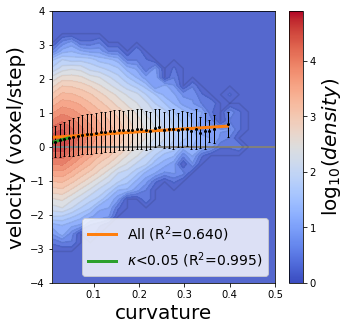

In [12]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plot
    bin_interval = 0.01
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_list = [[] for _ in range(bin_number)]

    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    print(f"{np.sum(np.array(new_curvature_1Dlist_remove_0step)<0.2)/len(new_curvature_1Dlist_remove_0step)*100}% GBs with curvature smaller than 0.2")
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list

    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_list[bin_idx].append(velocity_val)

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt(np.sum((np.array(velocity_bin_list[i]) - velocity_bin_means[i])**2) / curvature_bin_counts[i])

    
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    print(np.max(np.log10(hist.T)))
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=4.9)
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=4.9)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=4.9))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    # plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o-', c='k', linewidth=1)
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    
    # Linear fit for all valid bins
    x_all = curvature_coordinate[valid_bins]
    y_all = velocity_bin_means[valid_bins]
    p_all = np.polyfit(x_all, y_all, 1)
    y_pred_all = np.polyval(p_all, x_all)
    r2_all = 1 - np.sum((y_all - y_pred_all)**2) / np.sum((y_all - np.mean(y_all))**2)
    print(f"all points fitting: {r2_all}")
    print(f"all points slope: {p_all[0]}")
    
    # Linear fit for valid bins with curvature < 0.05
    mask_sub = x_all < 0.05
    x_sub = x_all[mask_sub]
    y_sub = y_all[mask_sub]
    if len(x_sub) > 1:
        p_sub = np.polyfit(x_sub, y_sub, 1)
        y_pred_sub = np.polyval(p_sub, x_sub)
        r2_sub = 1 - np.sum((y_sub - y_pred_sub)**2) / np.sum((y_sub - np.mean(y_sub))**2)
    else:
        r2_sub = np.nan
    print(f"smaller points fitting: {r2_sub}")
    print(f"smaller points slope: {p_sub[0]}")
    
    # Plot linear fits
    plt.plot(x_all, y_pred_all, '-', color='C1', linewidth=3, label=rf'All (R$^2$={r2_all:.3f})')
    if len(x_sub) > 1:
        plt.plot(x_sub, y_pred_sub, '-', color='C2', linewidth=3, label=rf'$\kappa$<0.05 (R$^2$={r2_sub:.3f})')
    plt.legend(loc='lower right', fontsize=14)
    
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

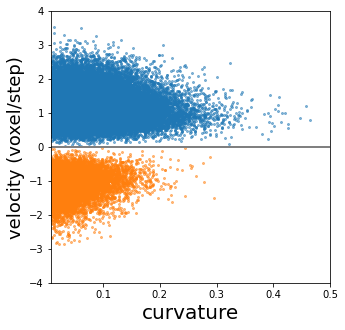

<Figure size 432x288 with 0 Axes>

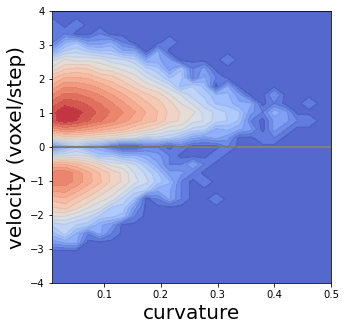

<Figure size 432x288 with 0 Axes>

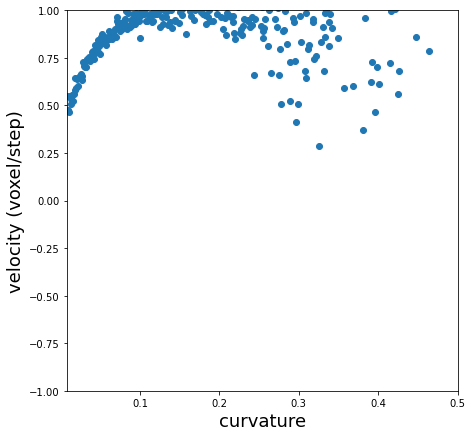

In [13]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>x_lim[1] or abs(new_curvature_1Dlist_remove_0step[index])<=x_lim[0]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

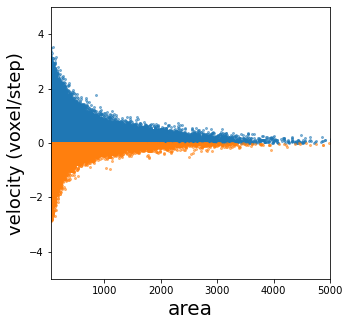

<Figure size 432x288 with 0 Axes>

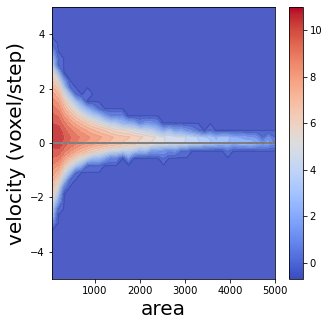

<Figure size 432x288 with 0 Axes>

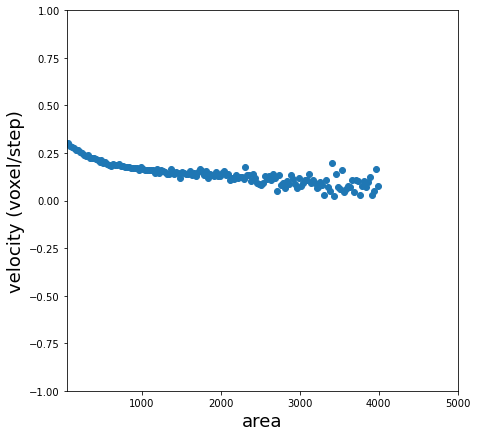

In [14]:
    # area VS velocity
    figure_name_all = f"figures/3D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.scatter(area_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(GB_normc_list_area_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_area_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([50,5000])
    plt.ylim([-5,5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 5050, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.2, 5.1, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_area_list+GB_antic_list_area_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/3D_velocity_area_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([50,5000],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=-0.7,vmax=11)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-0.7,vmax=11))
    cbar = plt.colorbar(sm)
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([50,5000])
    plt.ylim([-5.0,5.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged area
    bin_interval = 25
    x_lim = [50,4000]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    area_1Dlist_remove_0step = GB_normc_list_area_list + GB_antic_list_area_list
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    for index in range(len(area_1Dlist_remove_0step)):
        if abs(area_1Dlist_remove_0step[index])>=x_lim[1] or abs(area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,5000])
    plt.ylim([-1,1])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

average area is 291.91377729691067


<Figure size 432x288 with 0 Axes>

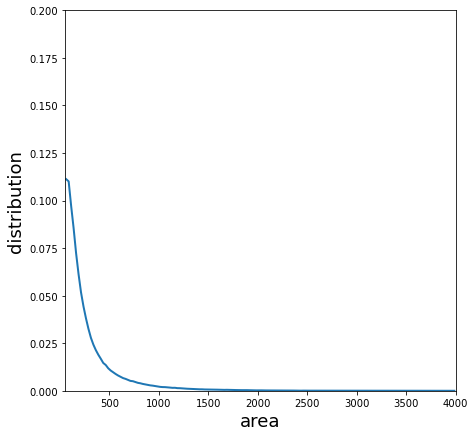

<Figure size 432x288 with 0 Axes>

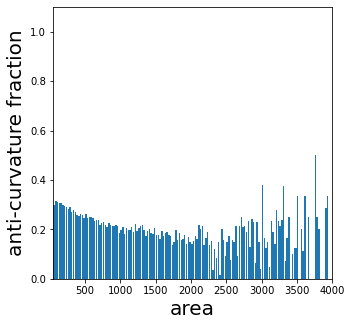

In [15]:
    # anti-c fraction VS area bin
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,4000])
    plt.ylim([0,0.2])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(f"figures/3D_area_distribution_{case_name}_5d.png", dpi=400,bbox_inches='tight')
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([50,4000])
    plt.ylim([0,1.1])
    # plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.bar(area_coordinate, antic_ratio_bin, width=bin_interval*0.8, color=f'C0')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("anti-curvature fraction", fontsize=20)
    plt.savefig(f"figures/3D_area_anti_{case_name}_5d.png", dpi=400,bbox_inches='tight')
    
    print(f"average area is {np.mean(area_1Dlist_remove_0step)}")

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

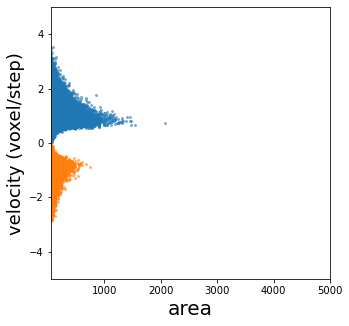

<Figure size 432x288 with 0 Axes>

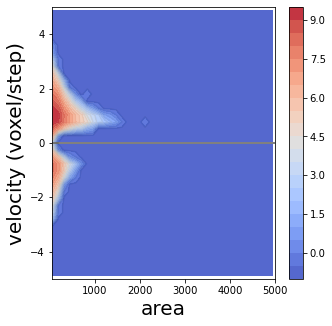

<Figure size 432x288 with 0 Axes>

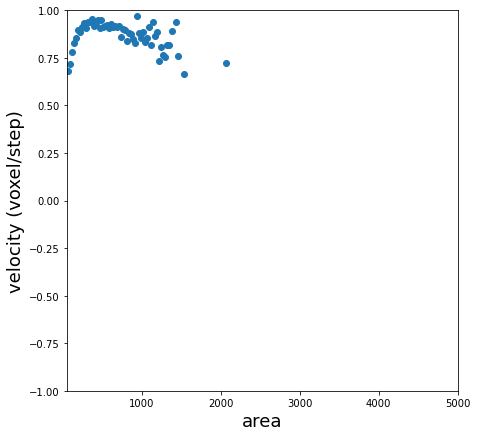

In [16]:
    # area VS velocity
    figure_name_all = f"figures/3D_velocity_area_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.scatter(area_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(update_GB_normc_list_area_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_area_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([50,5000])
    plt.ylim([-5,5])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 5000, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_area_list+update_GB_antic_list_area_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/3D_velocity_area_confi_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([50,5000],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.colorbar()
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([50,5000])
    plt.ylim([-5.0,5.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged area
    bin_interval = 25
    x_lim = [50,4000]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    new_area_1Dlist_remove_0step = update_GB_normc_list_area_list + update_GB_antic_list_area_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    for index in range(len(new_area_1Dlist_remove_0step)):
        if abs(new_area_1Dlist_remove_0step[index])>x_lim[1] or abs(new_area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_area_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,5000])
    plt.ylim([-1,1])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

average area is 291.91377729691067


<Figure size 432x288 with 0 Axes>

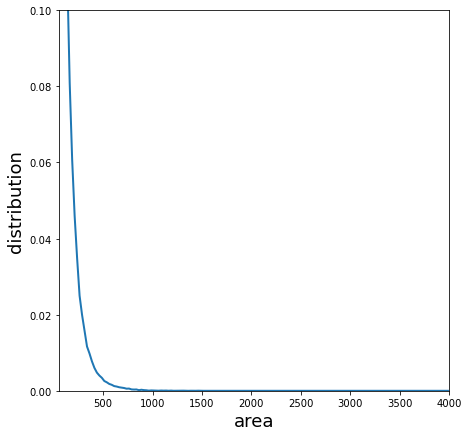

<Figure size 432x288 with 0 Axes>

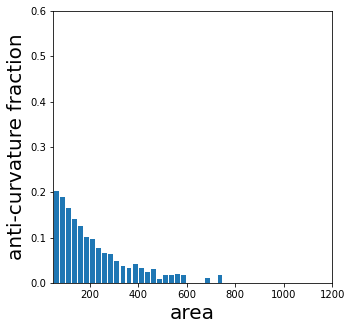

In [17]:
    # anti-c fraction VS area bin
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,4000])
    plt.ylim([0,0.1])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(f"figures/3D_area_distribution_confi_{case_name}_5d.png", dpi=400,bbox_inches='tight')
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([50,1200])
    plt.ylim([0,0.6])
    # plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.bar(area_coordinate[area_bin>4], antic_ratio_bin[area_bin>4], width=bin_interval*0.8, color=f'C0')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("anti-curvature fraction", fontsize=20)
    plt.savefig(f"figures/3D_area_antiC_confi_{case_name}_5d.png", dpi=400,bbox_inches='tight')
    
    print(f"average area is {np.mean(area_1Dlist_remove_0step)}")

Text(0, 0.5, 'GB energy')

<Figure size 432x288 with 0 Axes>

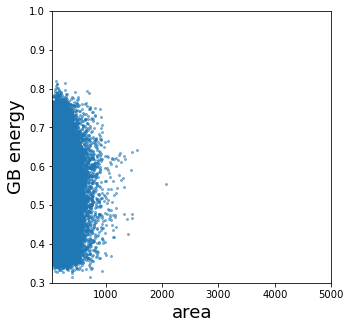

<Figure size 432x288 with 0 Axes>

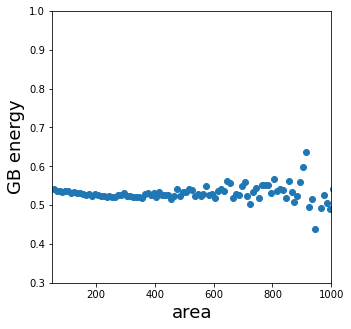

In [18]:
    # GB_energy VS area
    figure_name_all = f"figures/3D_GBenergy_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.scatter(area_1Dlist_remove_0step, GBenergy_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_area_list+update_GB_normc_list_area_list, 
                update_GB_antic_list_GBenergy_list+update_GB_normc_list_GBenergy_list,s=4,alpha=0.5)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("GB energy", fontsize=18)
    plt.xlim([50,5000])
    plt.ylim([0.3,1.0])
    # plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot GB energy VS area
    bin_interval = 10
    x_lim = [0,5000]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    new_area_1Dlist_remove_0step = update_GB_antic_list_area_list+update_GB_normc_list_area_list
    new_GBenergy_1Dlist_remove_0step = update_GB_antic_list_GBenergy_list+update_GB_normc_list_GBenergy_list
    for index in range(len(new_area_1Dlist_remove_0step)):
        if abs(new_area_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_area_1Dlist_remove_0step[index])<=x_lim[0]: continue
        area_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        GBenergy_bin[int((new_area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_GBenergy_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if area_bin[i]>0: GBenergy_bin[i] = GBenergy_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_GBenergy_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([50,1000])
    plt.ylim([0.3,1.0])
    plt.plot(area_coordinate[GBenergy_bin!=0], GBenergy_bin[GBenergy_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("GB energy", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

1.7399514617694338


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

/apps/python/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


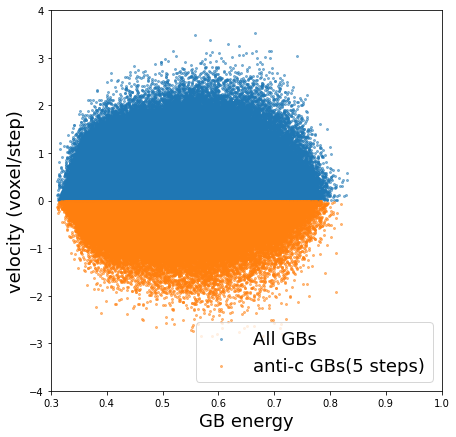

<Figure size 432x288 with 0 Axes>

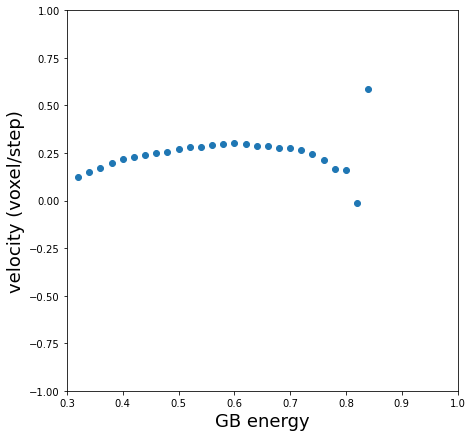

<Figure size 432x288 with 0 Axes>

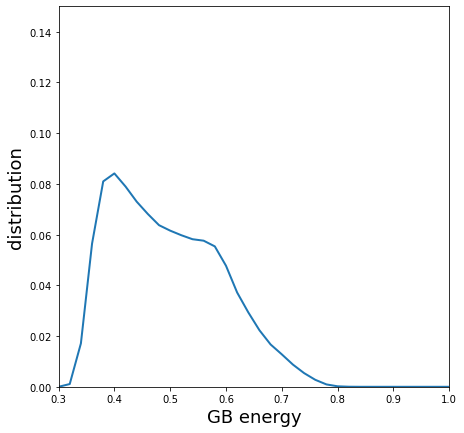

<Figure size 432x288 with 0 Axes>

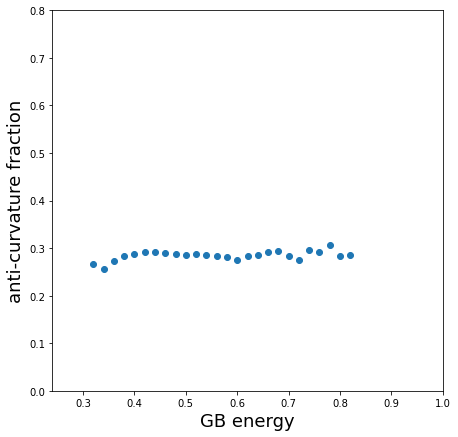

<Figure size 432x288 with 0 Axes>

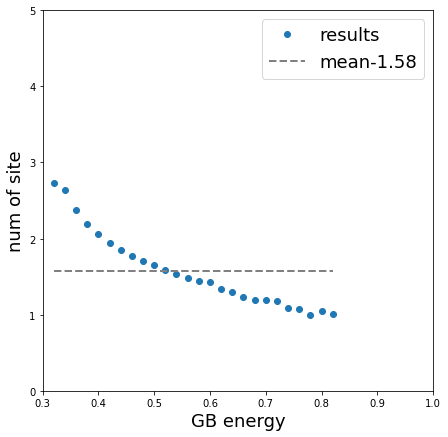

In [19]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list+GB_antic_list_velocity_list
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for index in range(len(GB_antic_list_GBenergy_list)):
        if abs(GB_antic_list_GBenergy_list[index])>=x_lim[1] or abs(GB_antic_list_GBenergy_list[index])<=x_lim[0]: continue
        antic_num_bin[int((GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.24,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


2.538239663169176


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

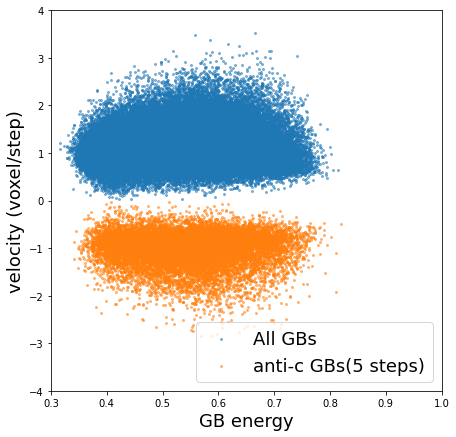

<Figure size 432x288 with 0 Axes>

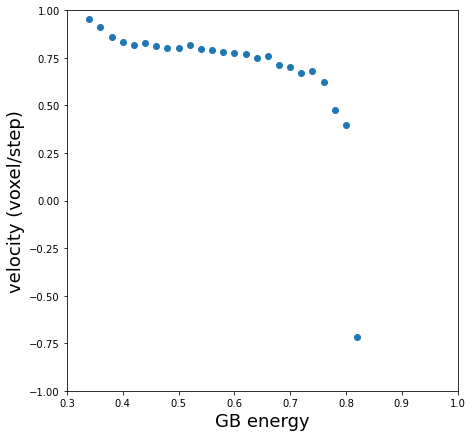

<Figure size 432x288 with 0 Axes>

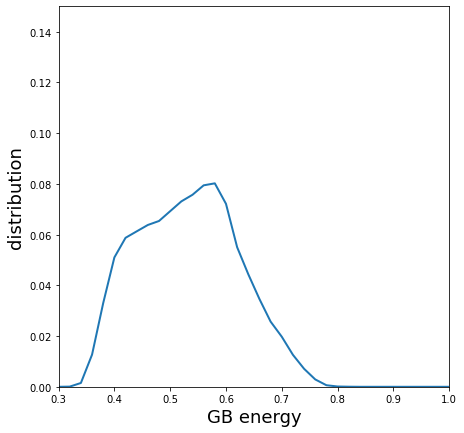

<Figure size 432x288 with 0 Axes>

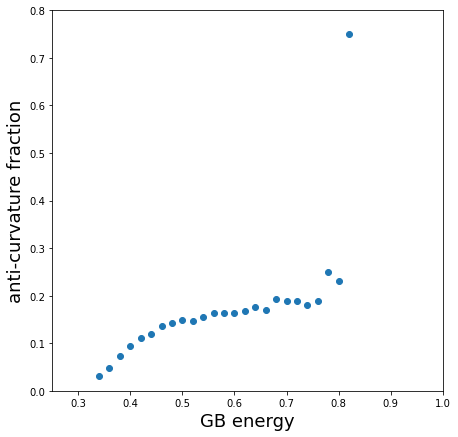

<Figure size 432x288 with 0 Axes>

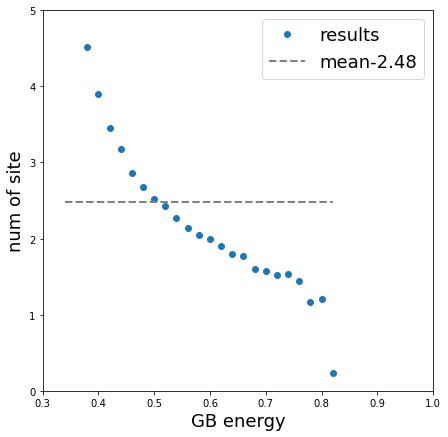

In [20]:

    figure_name_all = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.scatter(update_GB_normc_list_GBenergy_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(update_GB_antic_list_GBenergy_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.02
    x_lim = [0.25,1.01]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index])<=x_lim[0]: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        # if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for index in range(len(update_GB_antic_list_GBenergy_list)):
        if abs(update_GB_antic_list_GBenergy_list[index])>=x_lim[1] or abs(update_GB_antic_list_GBenergy_list[index])<=x_lim[0]: continue
        antic_num_bin[int((update_GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.25,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_confi_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


<Figure size 432x288 with 0 Axes>

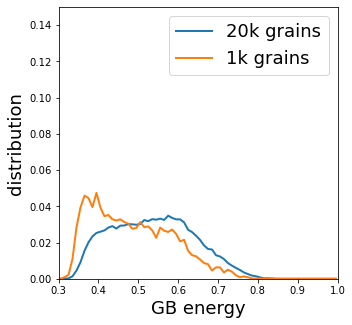

<Figure size 432x288 with 0 Axes>

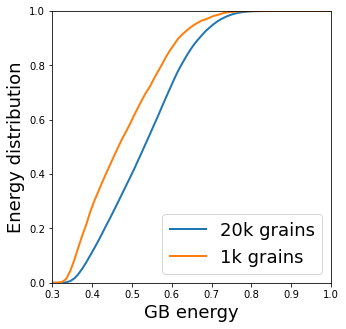

In [21]:
    # distribution for init and end
    figure_name_distri = f"figures/3D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/3D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Energy distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'curvature fraction')

<Figure size 432x288 with 0 Axes>

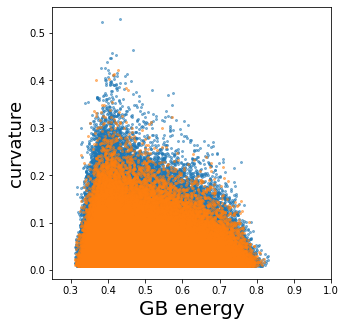

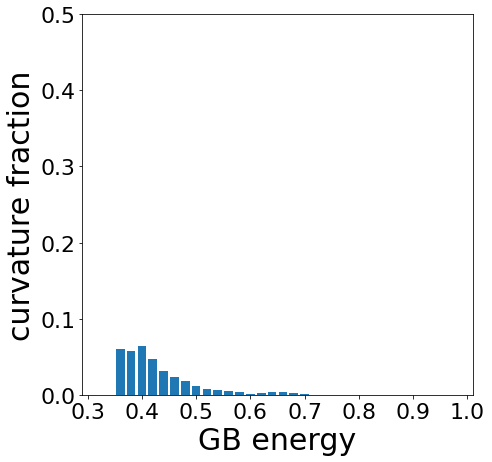

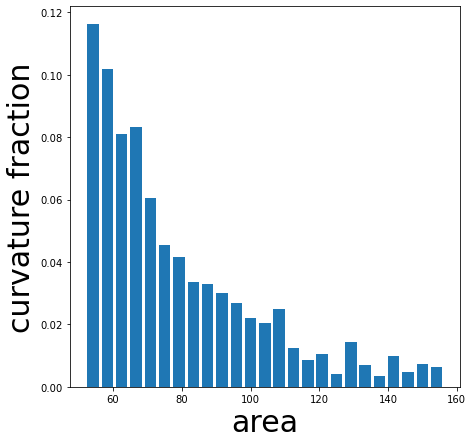

In [22]:
    # curvature VS GB energy
            
    figure_name_all = f"figures/3D_signedcurvature_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    # plt.plot([0.3,1.0],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_curvature_list, s=4,alpha=0.5)
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_curvature_list, s=4,alpha=0.5,color='C01')
    plt.xlabel("GB energy", fontsize=20)
    plt.ylabel("curvature", fontsize=18)
    plt.xlim([0.25,1.0])
    # plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot signedcurvature VS GBenergy
    bin_interval = 0.02
    x_lim = [0.29,1.01] # GB energy
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval) + bin_interval/2
    y_lim = [50,200] # area
    y_bin_interval = (y_lim[1]-y_lim[0])/bin_number
    area_coordinate = np.arange(y_lim[0],y_lim[1],y_bin_interval) + bin_interval/2

    curvature_bin = np.zeros(bin_number)
    curvature_fraction_energy_bin = np.zeros(bin_number)
    curvature_fraction_area_bin = np.zeros(bin_number)
    curvature_fraction_matrix = np.zeros((bin_number,bin_number))
    GBenergy_distribution_bin = np.zeros(bin_number)
    area_distribution_bin = np.zeros(bin_number)
    distribution_matrix_bin = np.zeros((bin_number,bin_number))
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list + GB_antic_list_GBenergy_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list + GB_antic_list_area_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        # prefactor: avoid GB energy larger 1 and get coordinate index
        if abs(new_GBenergy_1Dlist_remove_0step[index]) >= x_lim[1] or abs(new_GBenergy_1Dlist_remove_0step[index]) <= x_lim[0]: continue
        if abs(new_area_1Dlist_remove_0step[index]) >= y_lim[1] or abs(new_area_1Dlist_remove_0step[index]) <= y_lim[0]: continue
        GB_energy_index = int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)
        area_index = int((new_area_1Dlist_remove_0step[index]-y_lim[0])//y_bin_interval)
        # distribution
        GBenergy_distribution_bin[GB_energy_index] += 1
        area_distribution_bin[area_index] += 1
        distribution_matrix_bin[GB_energy_index,area_index] += 1
        # averaged curvature
        curvature_bin[GB_energy_index] += new_curvature_1Dlist_remove_0step[index]
        # calculate high curvature fraction vs GB energy or vs energy-area matrix
        if new_curvature_1Dlist_remove_0step[index] > 0.23:
            curvature_fraction_energy_bin[GB_energy_index] += 1  # calculate high curvature fraction vs GB energy
            curvature_fraction_area_bin[area_index] += 1  # calculate high curvature fraction vs area
            curvature_fraction_matrix[GB_energy_index,area_index] += 1 # calculate high curvature fraction vs energy-area matrix
    # normalized
    curvature_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin[GBenergy_distribution_bin>0] /= GBenergy_distribution_bin[GBenergy_distribution_bin>0]
    curvature_fraction_energy_bin /= np.sum(curvature_fraction_energy_bin)
    curvature_fraction_area_bin[area_distribution_bin>0] /= area_distribution_bin[area_distribution_bin>0]
    curvature_fraction_area_bin /= np.sum(curvature_fraction_area_bin)
    curvature_fraction_matrix[distribution_matrix_bin>0] /= distribution_matrix_bin[distribution_matrix_bin>0]
    curvature_fraction_matrix /= np.sum(curvature_fraction_matrix)
    
    figure_name_all_bin = f"figures/3D_signedcurvature_GBenergy_{case_name}_5d_afterBin.png"
    fig = plt.figure(figsize=(7, 7))
    plt.xlim(x_lim)
    plt.ylim([0,0.5])
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    mask_frequency = GBenergy_distribution_bin/np.sum(GBenergy_distribution_bin)>1e-2
    plt.bar(GBenergy_coordinate[mask_frequency], curvature_fraction_energy_bin[mask_frequency], width=bin_interval*0.8, color=f'C0', label='MI_cos')
    # plt.plot(GBenergy_coordinate, velocity_bin,'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)
    # plt.legend(fontsize=30)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim(x_lim)
    # plt.ylim([0,0.11])
    plt.bar(area_coordinate[GBenergy_distribution_bin>5], curvature_fraction_area_bin[GBenergy_distribution_bin>5], width=y_bin_interval*0.8, color=f'C0', label='MI_cos')
    # plt.plot(area_coordinate, curvature_fraction_area_bin, linewidth=2)
    plt.xlabel("area", fontsize=30)
    plt.ylabel("curvature fraction", fontsize=30)


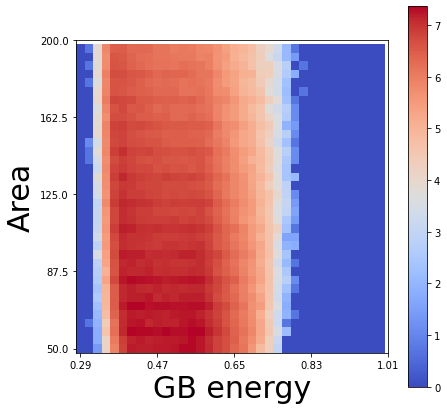

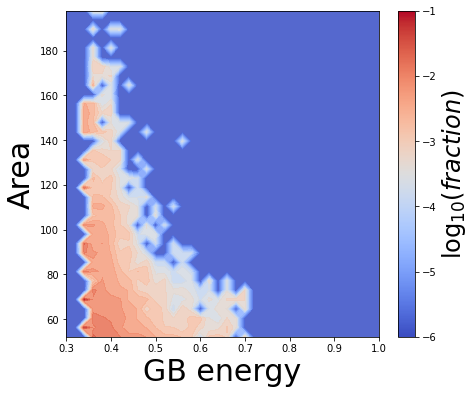

In [42]:
    # matrix distribution
    fig = plt.figure(figsize=(7,7))
    distribution_matrix_bin[distribution_matrix_bin==0]=1
    plt.imshow(np.log(distribution_matrix_bin.T),cmap='coolwarm')
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    cbar = plt.colorbar()
    plt.xticks(np.linspace(0,bin_number,5),np.round(np.linspace(x_lim[0],x_lim[1],5),2))
    plt.yticks(np.linspace(0,bin_number,5),np.round(np.linspace(y_lim[0],y_lim[1],5),2))
    plt.gca().invert_yaxis()
    
    
    x_bins = np.linspace( x_lim[0], x_lim[1], bin_number+1)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace( y_lim[0], y_lim[1], bin_number+1)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(new_GBenergy_1Dlist_remove_0step, new_area_1Dlist_remove_0step, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    figure_name_all = f"figures/3D_GBenergy_area_hotUpdate_{case_name}_5d.png"
    fig = plt.figure(figsize=(7,6))
    # curvature_fraction_matrix[curvature_fraction_matrix==0]=1
    # plt.imshow(curvature_fraction_matrix.T,cmap='coolwarm',vmax=0.01)
    curvature_fraction_matrix[curvature_fraction_matrix==0]=1e-6
    curvature_fraction_matrix[distribution_matrix_bin<=5]=1e-6
    plt.contourf(X, Y, np.log10(curvature_fraction_matrix.T), levels=20, cmap='coolwarm', alpha=0.9, vmin=-6,vmax=-1)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=-6,vmax=-1))
    cbar = plt.colorbar(sm)
    plt.xlabel("GB energy", fontsize=30)
    plt.ylabel("Area", fontsize=30)
    cbar.set_label(u"$\log_{10}(fraction)$", fontsize=24)
    # plt.xlim([50,5000])
    # plt.ylim([-5.0,5.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    

In [123]:
np.max(curvature_fraction_matrix[curvature_fraction_matrix!=0])

0.06856055010759121

## For one time step

In [1]:
 
    expected_grain_num = 5000
    
    # get corresponding step
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    for time_step in tqdm(range(npy_file_aniso.shape[0])):
        # Calculate the number of grains
        unique_id_num = len(np.unique(npy_file_aniso[time_step,:]))
        grain_num_array[time_step] = unique_id_num
        if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less
    expected_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))
    

NameError: name 'np' is not defined

In [25]:
    # fraction
    total_GB_num_1step = len(GB_infomation_dict_list[expected_step].keys())
    anti_c_num_1step = 0
    for key in GB_id_focus_detail:
        if expected_step in GB_id_focus_detail[key]: anti_c_num_1step += 1
    print(f"Anti-curvature GBs at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step}")
    print(f"Anti-curvature fraction at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step/total_GB_num_1step*100}% in {total_GB_num_1step} GBs")



Anti-curvature GBs at step 42 with 1000 grains is 2879
Anti-curvature fraction at step 42 with 1000 grains is 41.68235123787462% in 6907 GBs


<Figure size 432x288 with 0 Axes>

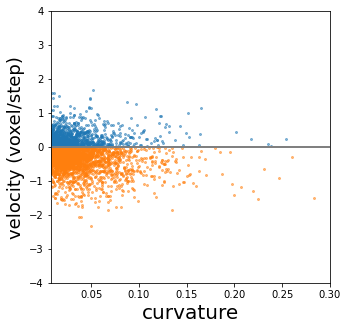

<Figure size 432x288 with 0 Axes>

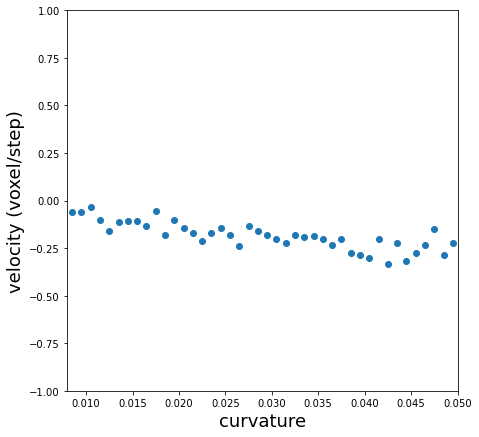

In [26]:
    # All in 1 figrue
    curvature_1Dlist_1step = GB_list_curvature_list[expected_step]
    velocity_1Dlist_1step = GB_list_velocity_list[expected_step]
    GBenergy_1Dlist_1step = GB_list_GBenergy_list[expected_step]
    GB_antic_list_curvature_1step = GB_antic_list_curvature_AllList[expected_step]
    GB_antic_list_velocity_1step = GB_antic_list_velocity_AllList[expected_step]
    GB_antic_list_GBenergy_1step = GB_antic_list_GBenergy_AllList[expected_step]
    GB_antic_list_anticNum_1step = GB_antic_list_anticNum_AllList[expected_step]
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_1step)):
        if curvature_1Dlist_1step[i]<0: 
            curvature_1Dlist_1step[i] = - curvature_1Dlist_1step[i]
            velocity_1Dlist_1step[i] = - velocity_1Dlist_1step[i]
    velocity_1Dlist_1step = np.array(velocity_1Dlist_1step)
    curvature_1Dlist_1step = np.array(curvature_1Dlist_1step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step>0], velocity_1Dlist_1step[velocity_1Dlist_1step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step<0], velocity_1Dlist_1step[velocity_1Dlist_1step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_1step, GB_antic_list_velocity_1step,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_1step)):
        if abs(curvature_1Dlist_1step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.05])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.5389069838006411


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

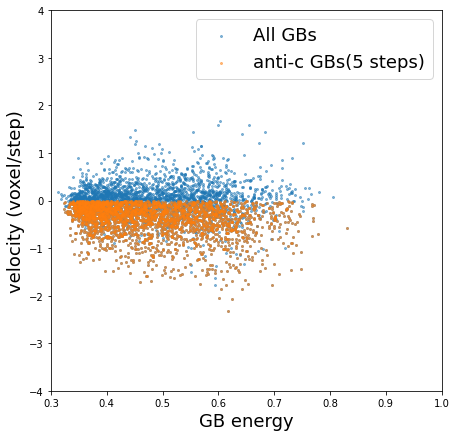

<Figure size 432x288 with 0 Axes>

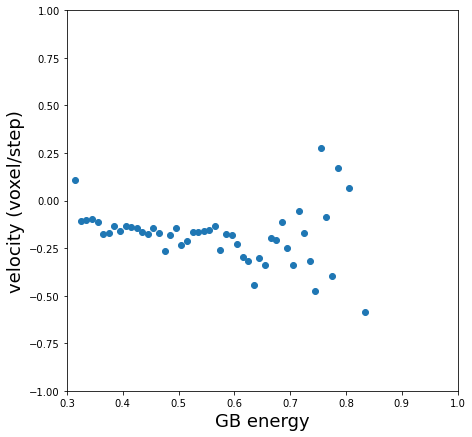

<Figure size 432x288 with 0 Axes>

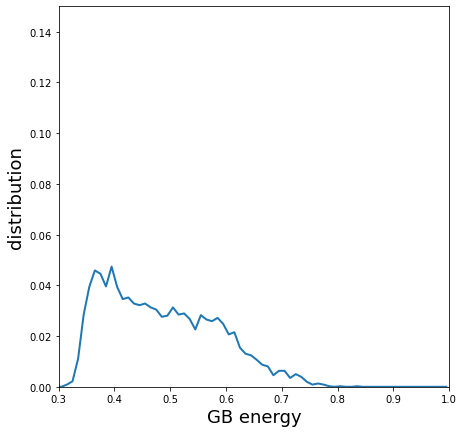

<Figure size 432x288 with 0 Axes>

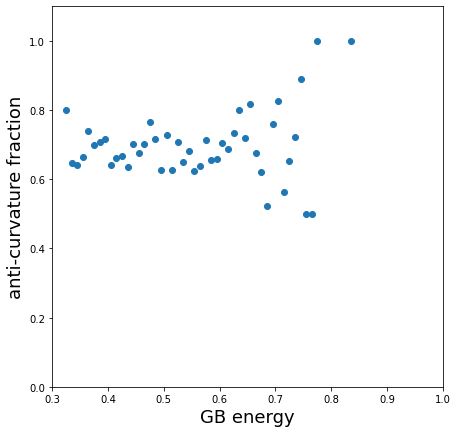

<Figure size 432x288 with 0 Axes>

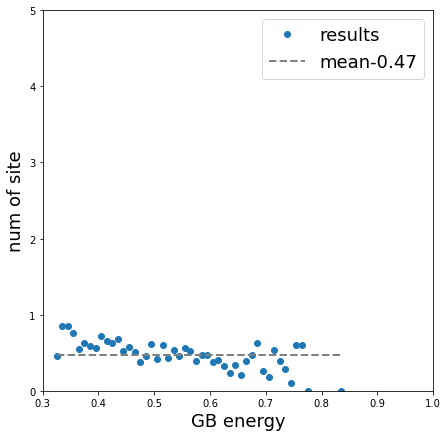

In [27]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_1step, velocity_1Dlist_1step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_1step = np.array(GB_antic_list_GBenergy_1step)
    GB_antic_list_velocity_1step = np.array(GB_antic_list_velocity_1step)
    GB_antic_list_anticNum_1step = np.array(GB_antic_list_anticNum_1step)
    plt.scatter(GB_antic_list_GBenergy_1step[GB_antic_list_anticNum_1step>=5], GB_antic_list_velocity_1step[GB_antic_list_anticNum_1step>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_1step)):
        if abs(GBenergy_1Dlist_1step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
        if velocity_1Dlist_1step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_1step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.1])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}_{expected_grain_num}grains"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [ ]:
dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])

## 3D anti-curvature example

In [ ]:
for key in GB_id_focus:
    if GB_id_focus[key] > 3:
        print(f"{key}: {GB_id_focus_detail[key]}")
        for time_step in GB_id_focus_detail[key]:
            dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
            if key in GB_infomation_dict_list[time_step]:
                result = dV_dict_tmp[key]
                # Calculate dV
                pair_id_pair_focus = GB_infomation_dict_list[time_step][key][6:8]
                # Calculate velocity
                velocity = result["velocity"]
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                
                # filter
                if abs(current_curvature_value) > 0.1 and GB_infomation_dict_list[time_step][key][5]/2 > 400:
                    print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> {time_step}: k {current_curvature_value} v {velocity}")


In [ ]:
# Get more information for a focus GB

# key_focus = 0
# for key in GB_id_focus:
#     if GB_id_focus[key] == 19: 
#         print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
#         key_focus = key
#         # break
# 94319196: [0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21] 9-22
# 10706086: 20-25
# 14531532: 9- 41
# 79228109: 1-20
key_focus = 79228109

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        # if current_curvature_value<0: 
        #     current_curvature_value = -current_curvature_value
        #     velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity: {round(velocity,3)} and curvature: {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-1.5,1.5])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






The id pairs are [5531, 12588]


  0%|          | 0/16 [00:00<?, ?it/s]

309
243
132


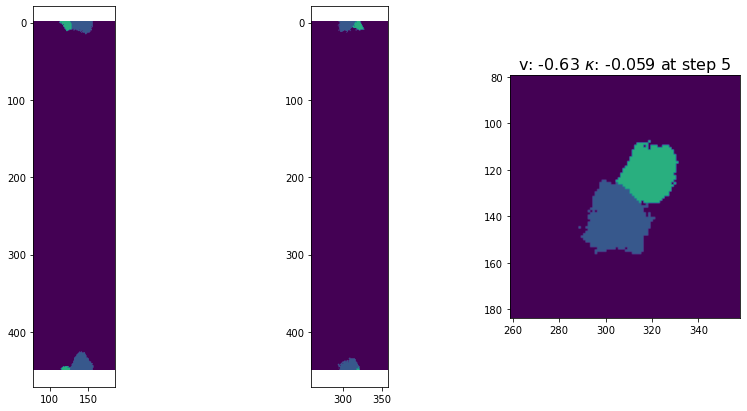

  6%|▋         | 1/16 [00:01<00:21,  1.43s/it]

309
243
132


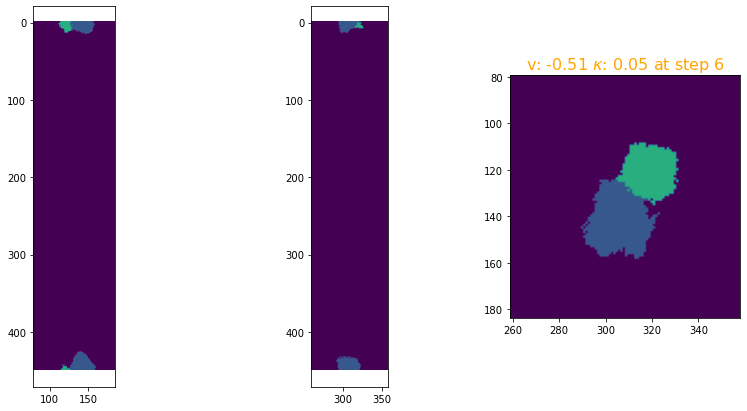

 12%|█▎        | 2/16 [00:02<00:17,  1.26s/it]

309
243
132


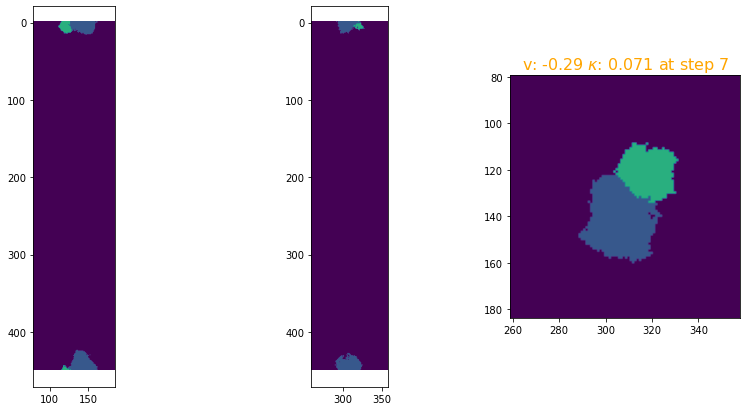

 19%|█▉        | 3/16 [00:03<00:16,  1.27s/it]

309
243
132


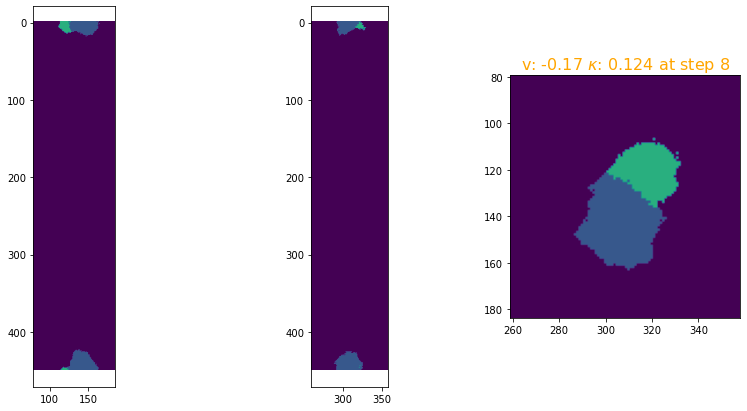

 25%|██▌       | 4/16 [00:05<00:15,  1.28s/it]

309
243
132


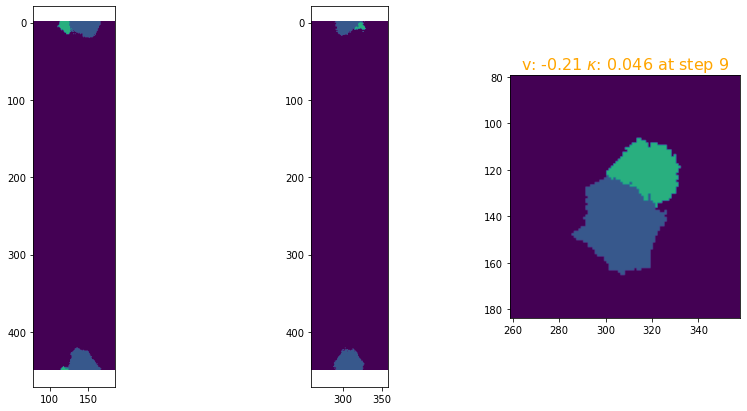

 31%|███▏      | 5/16 [00:06<00:13,  1.26s/it]

309
243
132


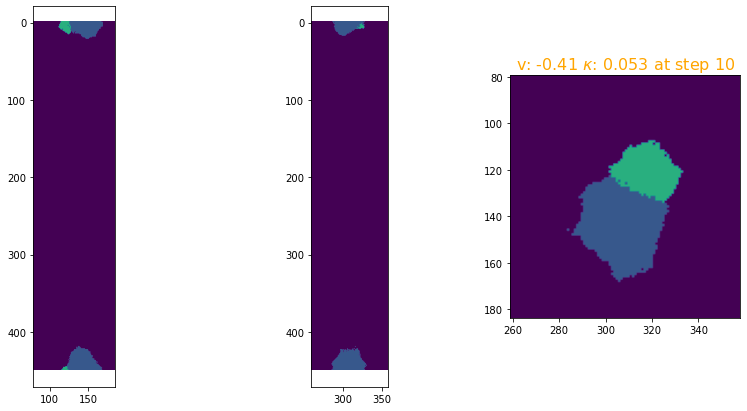

 38%|███▊      | 6/16 [00:07<00:12,  1.23s/it]

309
243
132


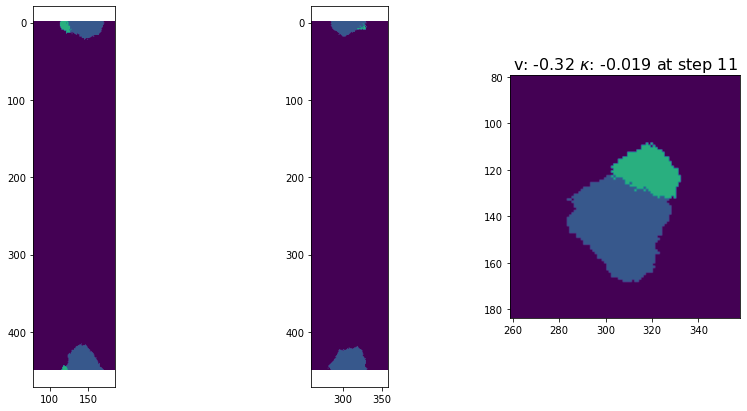

 44%|████▍     | 7/16 [00:09<00:12,  1.43s/it]

309
243
132


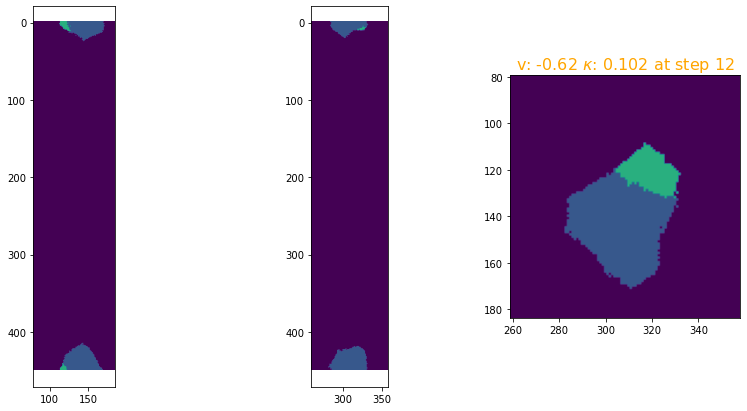

 50%|█████     | 8/16 [00:10<00:10,  1.37s/it]

309
243
132


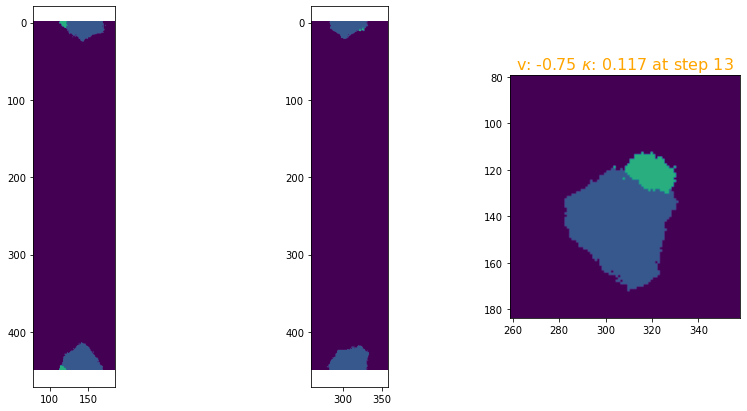

 56%|█████▋    | 9/16 [00:11<00:09,  1.35s/it]

309
243
132


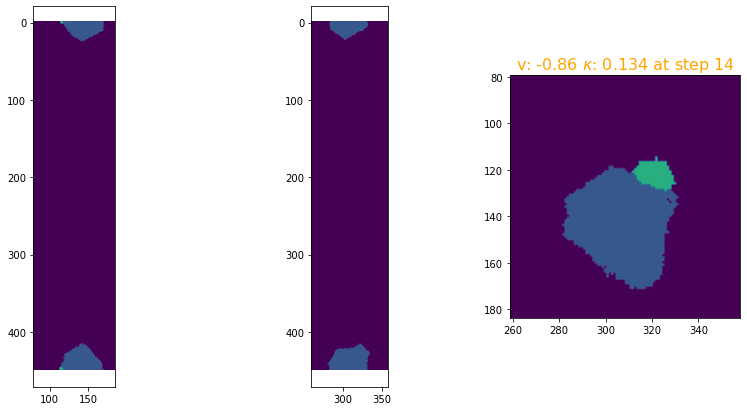

 62%|██████▎   | 10/16 [00:13<00:07,  1.32s/it]

309
243
132


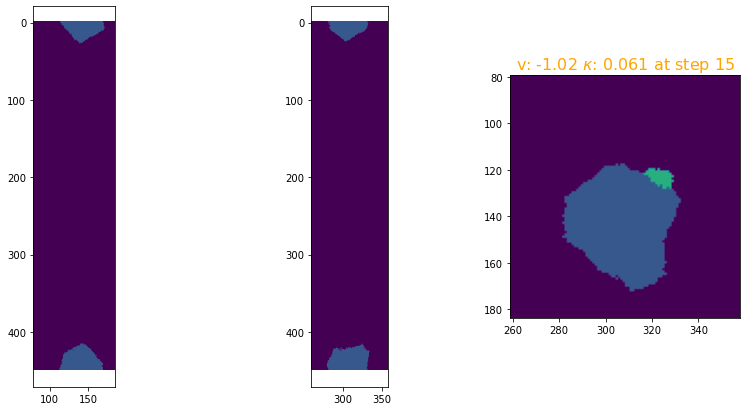

 69%|██████▉   | 11/16 [00:14<00:06,  1.26s/it]

309
243
132


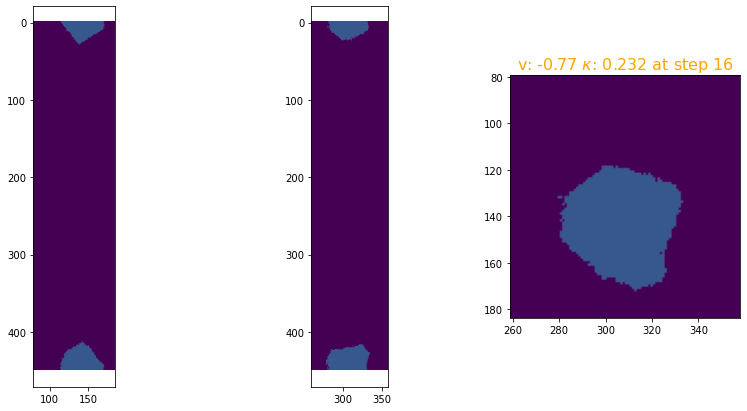

 75%|███████▌  | 12/16 [00:15<00:05,  1.26s/it]

309
243
132


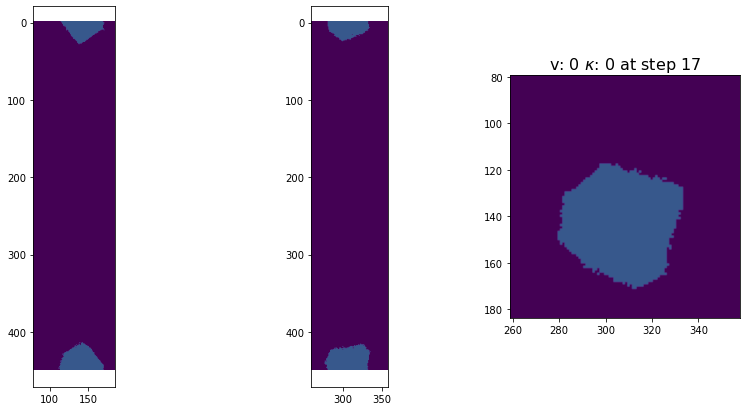

 81%|████████▏ | 13/16 [00:16<00:03,  1.08s/it]

309
243
132


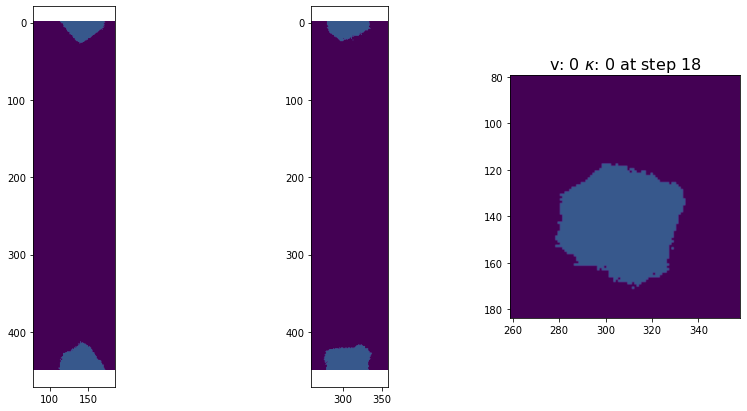

 88%|████████▊ | 14/16 [00:16<00:01,  1.05it/s]

309
243
132


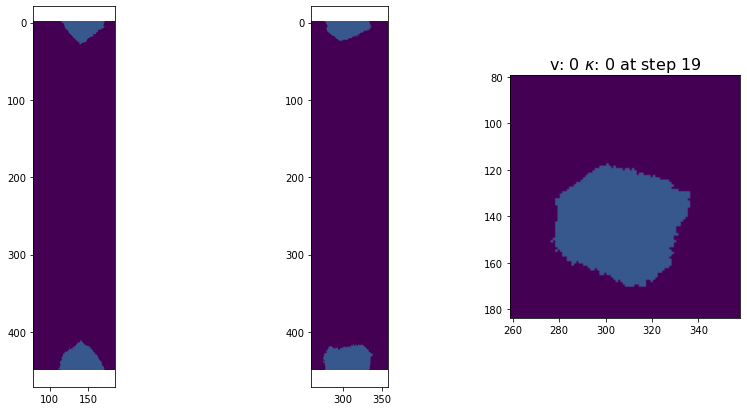

 94%|█████████▍| 15/16 [00:18<00:01,  1.11s/it]

309
243
132


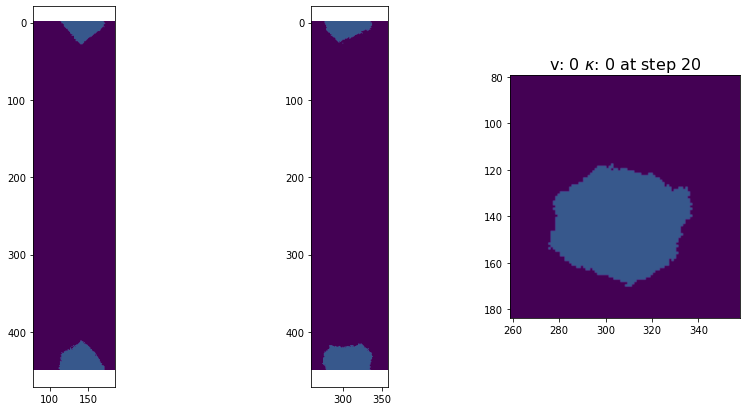

100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


In [24]:

# Find the exaxt grain id and time steps
GB_id = 79228109
for time_step in range(1,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 5, 21
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,:]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,450,1)[np.sum(grain_location_focus,axis=(1,2))*np.arange(0,450,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,450,1)[np.sum(grain_location_focus,(0,2))*np.arange(0,450,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        z_info = np.arange(0,450,1)[np.sum(grain_location_focus,(0,1))*np.arange(0,450,1)>0]
        z_len = np.sum(y_info>0)
        z_lim_max = int(np.max(z_info)+z_len/2)
        z_lim_min = int(np.min(z_info)-z_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    # if ss<10:
    #     ss_char = f'0{ss}'
    # else:
    #     ss_char = f'{ss}'
    ss_char = f'{ss}:02'
    ss+=1
    figure_name_anti_curvature_detail = f"anti_curvature_figures/Detail_3D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(14,7))
    plt.subplot(131)
    plt.imshow(current_microstructure_focus_updated[:,:,int(np.mean(z_info))],vmin=0,vmax=20000)
    print(int(np.mean(z_info)))
    plt.xlim([y_lim_min, y_lim_max])
    plt.ylim([x_lim_max, x_lim_min])
    plt.subplot(132)
    plt.imshow(current_microstructure_focus_updated[:,int(np.mean(y_info)),:],vmin=0,vmax=20000)
    print(int(np.mean(x_info)))
    plt.xlim([z_lim_min, z_lim_max])
    plt.ylim([x_lim_max, x_lim_min])
    plt.subplot(133)
    plt.imshow(current_microstructure_focus_updated[7,:,:],vmin=0,vmax=20000)
    print(int(np.mean(y_info)))
    plt.xlim([z_lim_min, z_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    plt.show()
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

The id pairs are [5531, 12588]


  0%|          | 0/20 [00:00<?, ?it/s]

131


  5%|▌         | 1/20 [00:02<00:42,  2.21s/it]

131


 10%|█         | 2/20 [00:04<00:37,  2.08s/it]

131


 15%|█▌        | 3/20 [00:06<00:34,  2.03s/it]

131


 20%|██        | 4/20 [00:08<00:32,  2.05s/it]

131


 25%|██▌       | 5/20 [00:10<00:30,  2.06s/it]

131


 30%|███       | 6/20 [00:12<00:28,  2.06s/it]

131


 35%|███▌      | 7/20 [00:14<00:26,  2.02s/it]

131


 40%|████      | 8/20 [00:16<00:24,  2.01s/it]

131


 45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

131


 50%|█████     | 10/20 [00:20<00:20,  2.04s/it]

131


 55%|█████▌    | 11/20 [00:22<00:18,  2.07s/it]

131


 60%|██████    | 12/20 [00:24<00:16,  2.03s/it]

131


 65%|██████▌   | 13/20 [00:27<00:15,  2.24s/it]

131


 70%|███████   | 14/20 [00:29<00:13,  2.17s/it]

131


 75%|███████▌  | 15/20 [00:31<00:10,  2.10s/it]

131


 80%|████████  | 16/20 [00:33<00:08,  2.06s/it]

131


 85%|████████▌ | 17/20 [00:35<00:06,  2.05s/it]

131


 90%|█████████ | 18/20 [00:36<00:03,  1.89s/it]

131


 95%|█████████▌| 19/20 [00:38<00:01,  1.76s/it]

131


100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


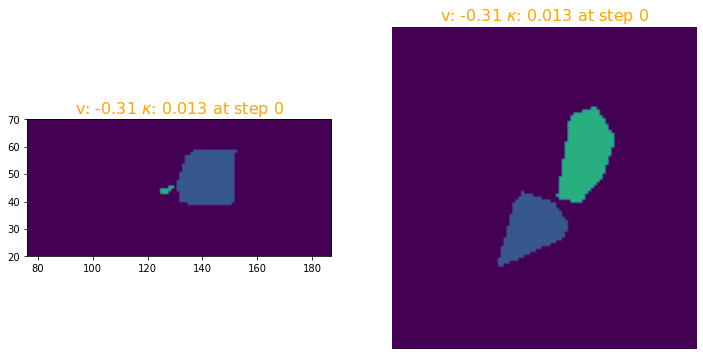

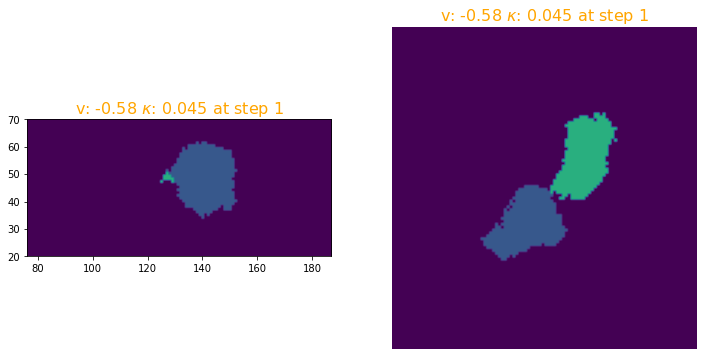

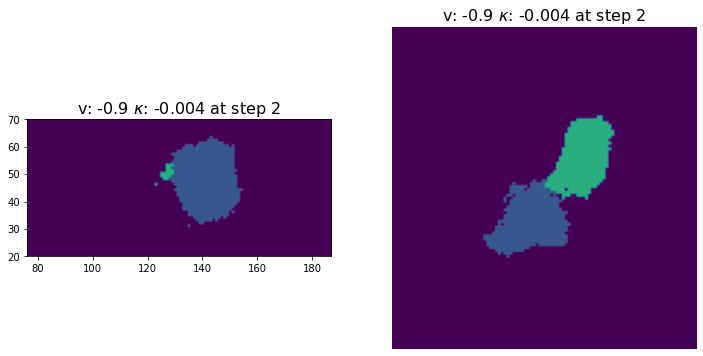

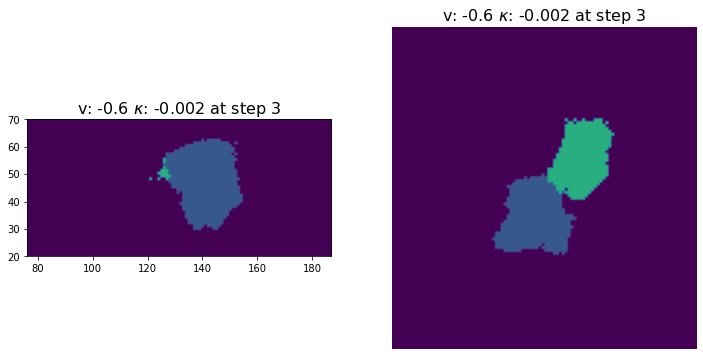

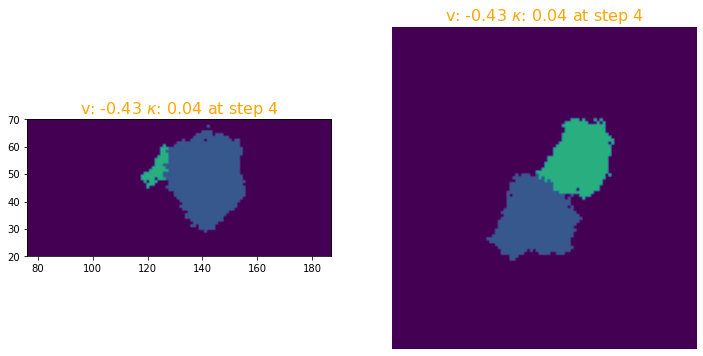

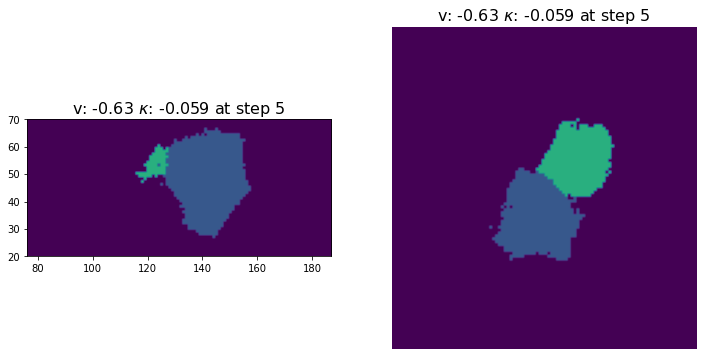

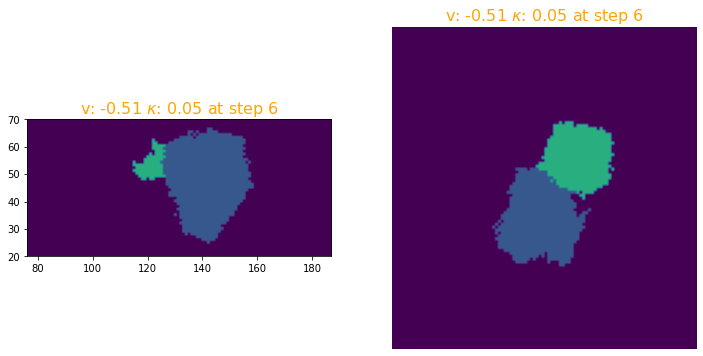

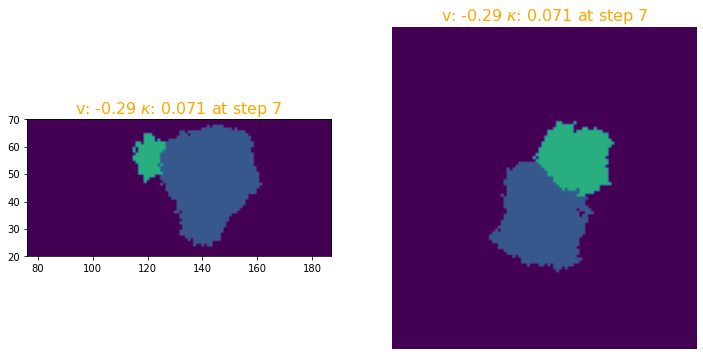

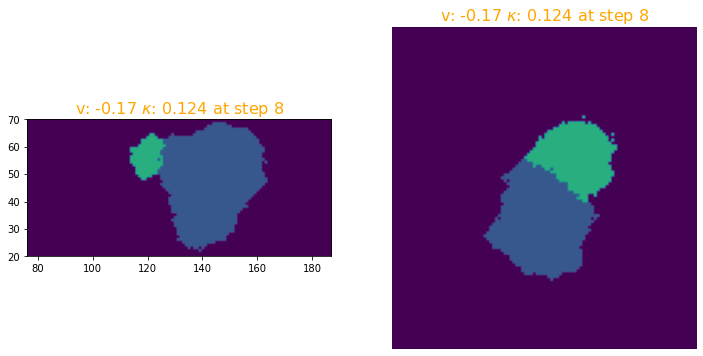

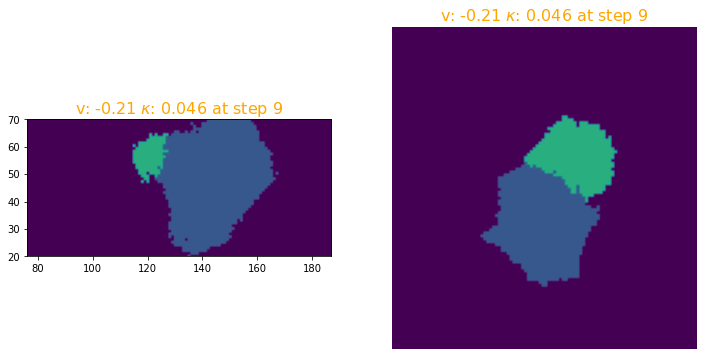

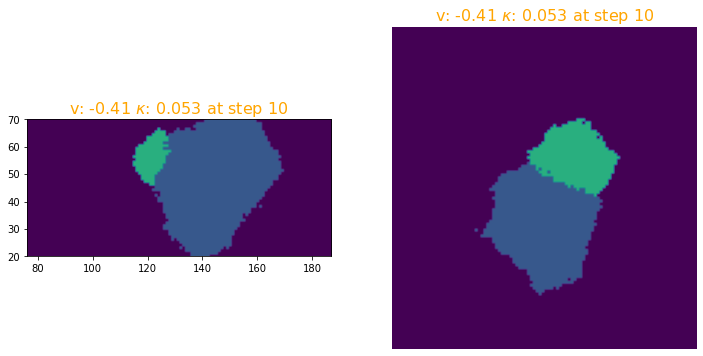

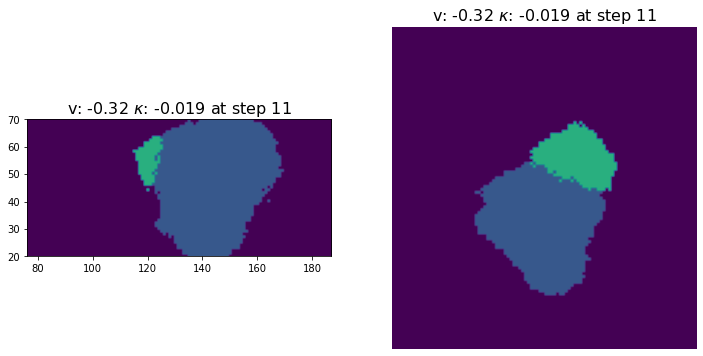

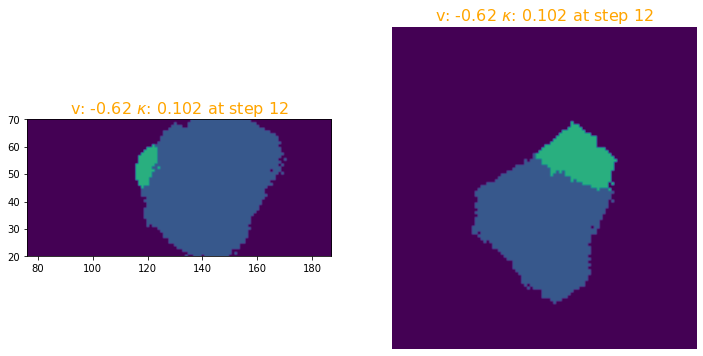

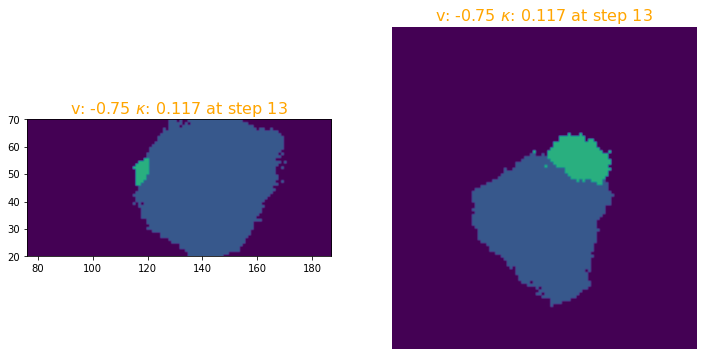

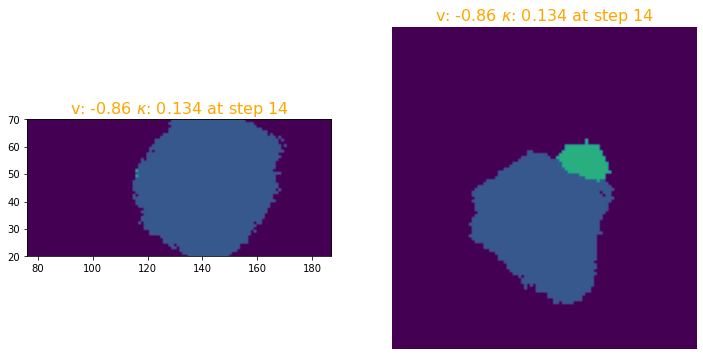

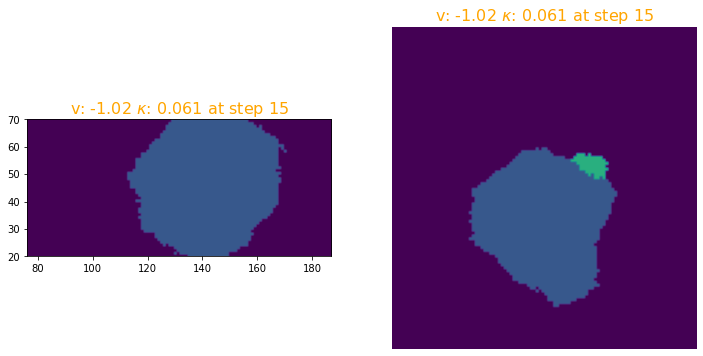

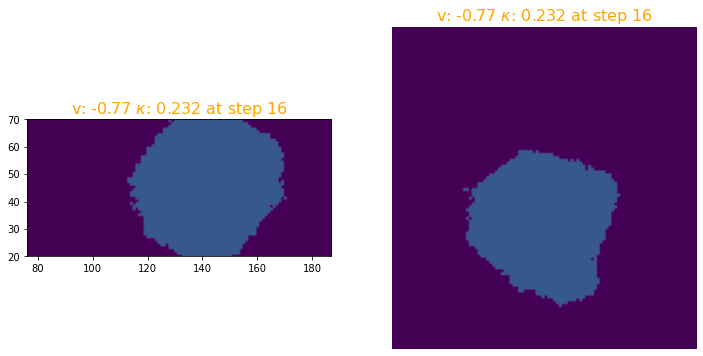

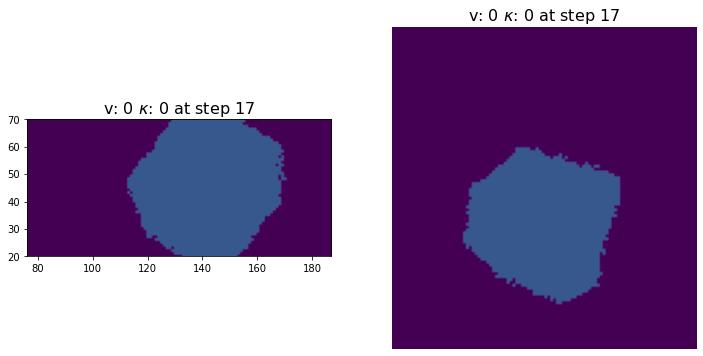

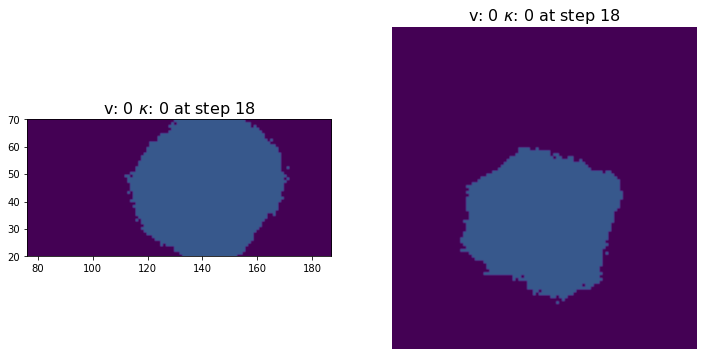

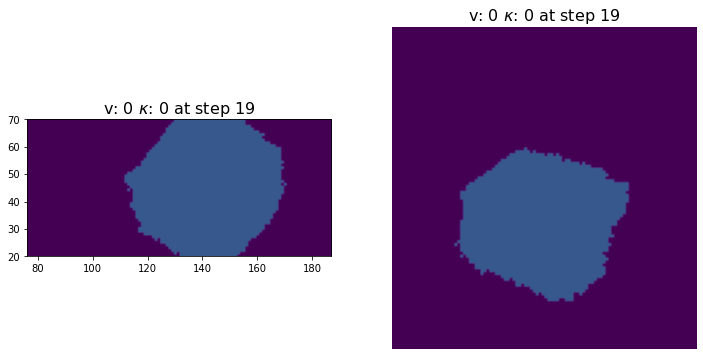

In [27]:

# Find the exaxt grain id and time steps
for time_step in range(1,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 0, 20
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,:]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,450,1)[np.sum(grain_location_focus,axis=(1,2))*np.arange(0,450,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,450,1)[np.sum(grain_location_focus,(0,2))*np.arange(0,450,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        z_info = np.arange(0,450,1)[np.sum(grain_location_focus,(0,1))*np.arange(0,450,1)>0]
        z_len = np.sum(y_info>0)
        z_lim_max = int(np.max(z_info)+z_len/2)
        z_lim_min = int(np.min(z_info)-z_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    ss_char = f'{ss:02}'
    ss+=1
    current_microstructure_focus_updated = np.roll(current_microstructure_focus_updated, shift=50, axis=0)
    figure_name_anti_curvature_detail = f"anti_curvature_figures/Detail_3D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(12,7))
    plt.subplot(121)
    # plt.imshow(current_microstructure_focus_updated[:,int(np.mean(y_info)+15),:],vmin=0,vmax=20000)
    plt.imshow(current_microstructure_focus_updated[:,:,int(np.mean(z_info))],vmin=0,vmax=20000)
    plt.xlim([y_lim_min, y_lim_max])
    plt.ylim([20, 70])
    # plt.ylim([x_lim_max, x_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    plt.subplot(122)
    plt.imshow(current_microstructure_focus_updated[57,:,:],vmin=0,vmax=20000)
    print(int(np.mean(y_info)))
    plt.xlim([z_lim_min, z_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.show()
    plt.axis("off")
    plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')
    

In [29]:
import os
os.system(f"rm anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_{case_name}.mp4")
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_3D_microstructure_key{GB_id}_step.%04d._{case_name}.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_{case_name}.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

## TJ study

In [40]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    # GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    # for key in GB_id_unfocus_lowE_detail:
    #     for key_time in GB_id_unfocus_lowE_detail[key]:
    #         if key_time in GB_id_unfocus_lowE_detail_time:
    #             GB_id_unfocus_lowE_detail_time[key_time].append(key)
    #         else: 
    #             GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]

In [41]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    # Compare the TJ movement around anti-c GBs and all TJ movement
            
    # TJ information
    step_num = 51
    TJ_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_TJ = f"GB_velocity_data/3D_TJ_information_data_{case_name}_step{time_step}_new.npz"
        
        if os.path.exists(data_file_folder + data_file_name_TJ):
            npz_file = np.load(data_file_folder + data_file_name_TJ,allow_pickle=True)
            TJ_information_dict = npz_file["TJ_information_dict"]
            TJ_information_dict_list.append(TJ_information_dict.item())
        else:
            TJ_information_dict = dict()
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            size_x, size_y, size_z = npy_file_aniso[time_step].shape
            for i in range(size_x):
                for j in range(size_y):
                    for k in range(size_z):
                        ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                        # find window and jump over GB and grain bulk
                        neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], 
                                                                current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], 
                                                                current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                                current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], 
                                                                current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], 
                                                                current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                                current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], 
                                                                current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], 
                                                                current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)

                        grain_id_num_in_window = np.unique(neighboring_sites_full_list) # the result is in order [1,2,3]
                        TJ_key_tuple = tuple(grain_id_num_in_window)
                        if len(grain_id_num_in_window) != 3: continue # jump over GBs and bulks and QJs

                        # keep TJ information
                        if TJ_key_tuple in TJ_information_dict:
                            # take the voxel on the edge into account
                            known_location = TJ_information_dict[TJ_key_tuple][:3]/TJ_information_dict[TJ_key_tuple][4]
                            current_location = np.array([i,j,k])
                            location_distance = known_location-current_location
                            location_distance_bool = abs(location_distance)>size_x/2
                            if np.sum(location_distance_bool)>0: 
                                i_new,j_new,k_new = current_location + (location_distance*location_distance_bool>0)*size_x+(location_distance*location_distance_bool<0)*-size_x
                                TJ_information_dict[TJ_key_tuple] += np.array([i_new,j_new,k_new, current_energy[i,j,k], 1])
                            else: 
                                TJ_information_dict[TJ_key_tuple] += np.array([i,j,k, current_energy[i,j,k], 1])
                        else:
                            TJ_information_dict[TJ_key_tuple] = np.array([i,j,k, current_energy[i,j,k], 1]) # i,j,k,TJenergy,TJnum
            # finish the normalize
            for TJ_key in TJ_information_dict:
                TJ_information_dict[TJ_key][:4] = TJ_information_dict[TJ_key][:4]/TJ_information_dict[TJ_key][4]
                if np.sum(TJ_information_dict[TJ_key][:3] < 0):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*size_x
                elif np.sum(TJ_information_dict[TJ_key][:3] >size_x):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*-size_x
            
            print(f"TJs in {time_step} step is {len(TJ_information_dict)}")
            wierd_TJ = 0
            for TJ_info in TJ_information_dict.values():
                if TJ_info[4] < 4: wierd_TJ+=1
            print(f"Weird TJs is {wierd_TJ}")
            # save information
            np.savez(data_file_folder + data_file_name_TJ, TJ_information_dict=TJ_information_dict)
            TJ_information_dict_list.append(TJ_information_dict)

            

  0%|          | 0/51 [00:00<?, ?it/s]

TJs in 0 step is 244272
Weird TJs is 33795


  2%|▏         | 1/51 [28:29<23:44:14, 1709.10s/it]

TJs in 1 step is 243041
Weird TJs is 15650


  4%|▍         | 2/51 [56:15<22:55:14, 1683.97s/it]

TJs in 2 step is 224933
Weird TJs is 14629


  6%|▌         | 3/51 [1:23:44<22:14:16, 1667.85s/it]

TJs in 3 step is 202321
Weird TJs is 14246


  8%|▊         | 4/51 [1:50:50<21:33:31, 1651.30s/it]

TJs in 4 step is 178533
Weird TJs is 12886


 10%|▉         | 5/51 [2:18:01<21:00:23, 1643.98s/it]

TJs in 5 step is 155891
Weird TJs is 10789


 12%|█▏        | 6/51 [2:44:59<20:26:21, 1635.15s/it]

TJs in 6 step is 137079
Weird TJs is 9205


 14%|█▎        | 7/51 [3:11:44<19:51:56, 1625.38s/it]

TJs in 7 step is 120817
Weird TJs is 7809


 16%|█▌        | 8/51 [3:38:13<19:16:31, 1613.76s/it]

TJs in 8 step is 106441
Weird TJs is 6510


 18%|█▊        | 9/51 [4:04:28<18:41:17, 1601.85s/it]

TJs in 9 step is 94243
Weird TJs is 5473


 20%|█▉        | 10/51 [4:30:31<18:06:19, 1589.74s/it]

TJs in 10 step is 83510
Weird TJs is 4695


 22%|██▏       | 11/51 [4:56:27<17:32:52, 1579.31s/it]

TJs in 11 step is 74692
Weird TJs is 3850


 24%|██▎       | 12/51 [5:22:20<17:01:29, 1571.52s/it]

TJs in 12 step is 67150
Weird TJs is 3224


 25%|██▌       | 13/51 [5:48:12<16:31:26, 1565.43s/it]

TJs in 13 step is 61153
Weird TJs is 2832


 27%|██▋       | 14/51 [6:13:58<16:01:41, 1559.50s/it]

TJs in 14 step is 55782
Weird TJs is 2542


 29%|██▉       | 15/51 [6:39:35<15:31:43, 1552.88s/it]

TJs in 15 step is 50745
Weird TJs is 2141


 31%|███▏      | 16/51 [7:05:05<15:01:52, 1546.06s/it]

TJs in 16 step is 46470
Weird TJs is 1938


 33%|███▎      | 17/51 [7:30:30<14:32:30, 1539.71s/it]

TJs in 17 step is 42666
Weird TJs is 1631


 35%|███▌      | 18/51 [7:55:48<14:03:17, 1533.24s/it]

TJs in 18 step is 39581
Weird TJs is 1402


 37%|███▋      | 19/51 [8:21:06<13:35:09, 1528.41s/it]

TJs in 19 step is 36798
Weird TJs is 1261


 39%|███▉      | 20/51 [8:46:19<13:07:23, 1524.00s/it]

TJs in 20 step is 34284
Weird TJs is 1207


 41%|████      | 21/51 [9:11:39<12:41:17, 1522.58s/it]

TJs in 21 step is 32151
Weird TJs is 1059


 43%|████▎     | 22/51 [9:36:51<12:14:22, 1519.40s/it]

TJs in 23 step is 28594
Weird TJs is 886


 47%|████▋     | 24/51 [10:27:18<11:22:22, 1516.38s/it]

TJs in 24 step is 27140
Weird TJs is 867


 49%|████▉     | 25/51 [10:52:20<10:55:08, 1511.86s/it]

TJs in 25 step is 25514
Weird TJs is 718


 51%|█████     | 26/51 [11:17:13<10:27:39, 1506.38s/it]

TJs in 26 step is 24188
Weird TJs is 702


 53%|█████▎    | 27/51 [11:42:03<10:00:32, 1501.33s/it]

TJs in 27 step is 22921
Weird TJs is 667


 57%|█████▋    | 29/51 [12:31:42<9:08:08, 1494.92s/it] 

TJs in 28 step is 21733
Weird TJs is 608


 59%|█████▉    | 30/51 [12:56:23<8:41:50, 1490.97s/it]

TJs in 29 step is 20569
Weird TJs is 567


 61%|██████    | 31/51 [13:21:01<8:15:37, 1486.90s/it]

TJs in 30 step is 19576
Weird TJs is 575


 63%|██████▎   | 32/51 [13:45:30<7:49:11, 1481.67s/it]

TJs in 31 step is 18526
Weird TJs is 473


 65%|██████▍   | 33/51 [14:10:12<7:24:31, 1481.74s/it]

TJs in 32 step is 17567
Weird TJs is 452


 67%|██████▋   | 34/51 [14:34:43<6:58:51, 1478.32s/it]

TJs in 33 step is 16855
Weird TJs is 448


 69%|██████▊   | 35/51 [14:59:07<6:33:06, 1474.16s/it]

TJs in 34 step is 16048
Weird TJs is 344
TJs in 35 step is 15496
Weird TJs is 341


 73%|███████▎  | 37/51 [15:47:36<5:41:19, 1462.81s/it]

TJs in 36 step is 14818
Weird TJs is 318


 75%|███████▍  | 38/51 [16:11:46<5:16:08, 1459.13s/it]

TJs in 37 step is 14279
Weird TJs is 321


 76%|███████▋  | 39/51 [16:34:40<4:46:40, 1433.39s/it]

TJs in 38 step is 13694
Weird TJs is 336
TJs in 39 step is 13059
Weird TJs is 246


 80%|████████  | 41/51 [17:19:50<3:52:12, 1393.25s/it]

TJs in 40 step is 12611
Weird TJs is 229


 82%|████████▏ | 42/51 [17:42:31<3:27:32, 1383.58s/it]

TJs in 41 step is 12259
Weird TJs is 254


 84%|████████▍ | 43/51 [18:05:03<3:03:12, 1374.10s/it]

TJs in 42 step is 11810
Weird TJs is 220


 86%|████████▋ | 44/51 [18:27:32<2:39:26, 1366.70s/it]

TJs in 43 step is 11383
Weird TJs is 233


 88%|████████▊ | 45/51 [18:50:02<2:16:10, 1361.74s/it]

TJs in 44 step is 10971
Weird TJs is 228


 90%|█████████ | 46/51 [19:12:28<1:53:04, 1356.94s/it]

TJs in 45 step is 10617
Weird TJs is 224


 92%|█████████▏| 47/51 [19:35:00<1:30:21, 1355.39s/it]

TJs in 46 step is 10201
Weird TJs is 205


 94%|█████████▍| 48/51 [19:57:31<1:07:42, 1354.13s/it]

TJs in 47 step is 9908
Weird TJs is 202


 96%|█████████▌| 49/51 [20:20:13<45:12, 1356.40s/it]  

TJs in 48 step is 9582
Weird TJs is 153


 98%|█████████▊| 50/51 [20:42:45<22:35, 1355.11s/it]

TJs in 49 step is 9312
Weird TJs is 193


100%|██████████| 51/51 [21:05:25<00:00, 1488.74s/it]

TJs in 50 step is 8951
Weird TJs is 159


In [42]:
    # extract TJ velocity
    time_interval = 2
    TJ_velocity_list = []
    TJ_velocity_1Dlist = []
    TJ_focus_velocity_list = []
    TJ_focus_velocity_1Dlist = []
    TJ_energy_list = []
    TJ_energy_1Dlist = []
    TJ_focus_energy_list = []
    TJ_focus_energy_1Dlist = []
    TJ_GBenergy_list = []
    TJ_GBenergy_1Dlist = []
    TJ_GBenergy_1Dlist_three = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_three = [[],[],[]]
    TJ_focus_GBenergy_list = []
    TJ_focus_GBenergy_1Dlist = []
    TJ_focus_GBenergy_1Dlist_three = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_three = [[],[],[]]
    # dict for GB
    GB_with_four_GBenergy_diff = dict()
    GB_focus_with_four_GBenergy_diff = dict()
    for time_step in range(step_num):
        if time_step + 1 >= step_num: continue
        TJ_velocity_list_tmp = []
        TJ_energy_list_tmp = []
        TJ_focus_velocity_list_tmp = []
        TJ_focus_energy_list_tmp = []
        TJ_GBenergy_list_tmp = []
        TJ_GBenergy_list_three_tmp = []
        TJ_focus_GBenergy_list_tmp = []
        TJ_focus_GBenergy_list_three_tmp = []
        for TJ_key in tqdm(TJ_information_dict_list[time_step]):
            if TJ_information_dict_list[time_step+1].get(TJ_key) is None: continue
            edge_matrix = np.array([[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[0,0,size_z],[0,0,-size_z],
                                    [size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0],
                                    [size_x,size_y,size_z],[-size_x,-size_y,size_z],[-size_x,size_y,size_z],[size_x,-size_y,size_z],
                                    [size_x,size_y,-size_z],[-size_x,-size_y,-size_z],[-size_x,size_y,-size_z],[size_x,-size_y,-size_z]])
            
            # calculate three GB energy
            GB_key1_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[1])
            GB_key2_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[2])
            GB_key3_at_TJ = post_processing.get_line(TJ_key[1],TJ_key[2])
            if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                
                GB_key1_energy = GBenergy_information_dict_list[time_step][GB_key1_at_TJ][4]
                GB_key2_energy = GBenergy_information_dict_list[time_step][GB_key2_at_TJ][4]
                GB_key3_energy = GBenergy_information_dict_list[time_step][GB_key3_at_TJ][4]
                GB_3keys_energy = [GB_key1_energy,GB_key2_energy,GB_key3_energy]
                GB_3keys_energy_left = [GB_key2_energy,GB_key3_energy,GB_key1_energy]
                GB_3keys_energy.sort()
                TJ_GBenergy_list_tmp.extend(GB_3keys_energy)
                TJ_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                TJ_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                TJ_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                GB_3diff_energy = abs(np.array(GB_3keys_energy_left) - np.array(GB_3keys_energy))
                TJ_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                TJ_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                TJ_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                
                # keep four GB energy diff for each GB
                for current_index, current_GB_key in enumerate([GB_key1_at_TJ,GB_key2_at_TJ,GB_key3_at_TJ]):
                    keep_energy_three = abs(np.array(GB_3keys_energy)-GB_3keys_energy[current_index])
                    keep_energy_two = np.delete(keep_energy_three, [current_index])
                    if (time_step,current_GB_key) in GB_with_four_GBenergy_diff:
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend(list(keep_energy_two))
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                    else: 
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)] = list(keep_energy_two)
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                
                
            
            # get two points location
            location_next_step = TJ_information_dict_list[time_step+1][TJ_key][:3]
            location_current = TJ_information_dict_list[time_step][TJ_key][:3]
            # get distance between two points, "not in edge" and "in edge" cases
            if np.linalg.norm(location_next_step-location_current) < size_x/10:
                distance = np.linalg.norm(location_next_step-location_current)
            else:
                difference_8points = np.tile(location_next_step,(18,1)) + edge_matrix - np.tile(location_current,(18,1))
                distance_8points = np.linalg.norm(difference_8points,axis=1)
                distance = np.min(distance_8points)
            # calculate velocity
            velocity = distance / time_interval
            TJ_velocity_list_tmp.append(velocity)
            # TJ averaged energy
            TJ_energy = TJ_information_dict_list[time_step][TJ_key][3]
            TJ_energy_list_tmp.append(TJ_energy)
            
            # consider the TJ around the anti-c GB
            if time_step not in GB_id_focus_detail_time: continue
            else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
            for GB_key in current_focus_GB_id:
                pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_key][6:8]
                # We take the difference of two other GB and anti-c GB into account
                
#                 if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
#                     # current TJ is around anti-c GB
#                     TJ_focus_velocity_list_tmp.append(velocity)
#                     TJ_focus_energy_list_tmp.append(TJ_energy)
                    
#                     # get the third grain id
#                     for grain_id in TJ_key:
#                         if grain_id not in pair_id_pair_focus:
#                             grain_id_third_grain = grain_id
                    
#                     # get the velocity direction
#                     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#                     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#                     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#                     velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_key][5]/2) # 1 direction get negative, 0 get positive
#                     # Get the GB key same as velocity direction and opposite to v direciton
#                     if velocity>0:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                     else:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
                        
#                     if (GB_key_positive_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key_negative_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key in GBenergy_information_dict_list[time_step]):    
#                         TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy) # old information
                    
#                         # get the energy for the two GB keys
#                         GB_key_pv_energy = GBenergy_information_dict_list[time_step][GB_key_positive_velocity][4]
#                         GB_key_nv_energy = GBenergy_information_dict_list[time_step][GB_key_negative_velocity][4]
#                         GB_antic_energy = GBenergy_information_dict_list[time_step][GB_key][4]
#                         # keep
#                         TJ_focus_GBenergy_1Dlist_two[0].append(GB_key_pv_energy-GB_antic_energy)
#                         TJ_focus_GBenergy_1Dlist_two[1].append(GB_key_nv_energy-GB_antic_energy)
                    
#                     break # because each TJ will have maximum of one anti-c GB
                
                
                
                if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                    # current TJ is around anti-c GB
                    TJ_focus_velocity_list_tmp.append(velocity)
                    TJ_focus_energy_list_tmp.append(TJ_energy)
                    # calculate three GB energy
                    if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                        TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy)
                        TJ_focus_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                        TJ_focus_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                        TJ_focus_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                        TJ_focus_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                        TJ_focus_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                        TJ_focus_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                        
                        # keep four GB energy difference on anti-c GB
                        GB_focus_with_four_GBenergy_diff[(time_step,GB_key)] = GB_with_four_GBenergy_diff[(time_step,GB_key)]
                    break
            
        
        print(f"All TJs in {time_step} step is {len(TJ_velocity_list_tmp)}, focused TJs is {len(TJ_focus_velocity_list_tmp)}")
        TJ_velocity_list.append(TJ_velocity_list_tmp)
        TJ_velocity_1Dlist.extend(TJ_velocity_list_tmp)
        TJ_focus_velocity_list.append(TJ_focus_velocity_list_tmp)
        TJ_focus_velocity_1Dlist.extend(TJ_focus_velocity_list_tmp)
        TJ_energy_list.append(TJ_energy_list_tmp)
        TJ_energy_1Dlist.extend(TJ_energy_list_tmp)
        TJ_focus_energy_list.append(TJ_focus_energy_list_tmp)
        TJ_focus_energy_1Dlist.extend(TJ_focus_energy_list_tmp)
        TJ_GBenergy_list.append(TJ_GBenergy_list_tmp)
        TJ_GBenergy_1Dlist.extend(TJ_GBenergy_list_tmp)
        TJ_focus_GBenergy_list.append(TJ_focus_GBenergy_list_tmp)
        TJ_focus_GBenergy_1Dlist.extend(TJ_focus_GBenergy_list_tmp)
        
    # clean the data for four GB energy on GB object
    GB_four_GBenergy_values = list(GB_with_four_GBenergy_diff.values())
    GB_focus_four_GBenergy_values = list(GB_focus_with_four_GBenergy_diff.values())
    GB_four_GBenergy_values_update = []
    GB_focus_four_GBenergy_values_update = []
    for i in range(len(GB_four_GBenergy_values)):
        if len(GB_four_GBenergy_values[i]) == 6: GB_four_GBenergy_values_update.append(GB_four_GBenergy_values[i])
    for i in range(len(GB_focus_four_GBenergy_values)):
        if len(GB_focus_four_GBenergy_values[i]) == 6: GB_focus_four_GBenergy_values_update.append(GB_focus_four_GBenergy_values[i])
    # only keep ave min max for it
    TJ_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_four_all = []
    TJ_focus_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_four_all = []
    for i in range(len(GB_four_GBenergy_values_update)):
        TJ_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[1].append(np.min(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[2].append(np.max(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four_all.extend(GB_four_GBenergy_values_update[i])
    for i in range(len(GB_focus_four_GBenergy_values_update)):
        TJ_focus_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[1].append(np.min(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[2].append(np.max(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four_all.extend(GB_focus_four_GBenergy_values_update[i])
    


        

100%|██████████| 244272/244272 [00:18<00:00, 13160.73it/s]


All TJs in 0 step is 202867, focused TJs is 0


100%|██████████| 243041/243041 [00:17<00:00, 13515.32it/s]


All TJs in 1 step is 198023, focused TJs is 0


100%|██████████| 224933/224933 [00:15<00:00, 14189.32it/s]


All TJs in 2 step is 172816, focused TJs is 0


100%|██████████| 202321/202321 [15:29<00:00, 217.73it/s]


All TJs in 3 step is 149815, focused TJs is 46825


100%|██████████| 178533/178533 [15:47<00:00, 188.35it/s]


All TJs in 4 step is 130731, focused TJs is 54358


100%|██████████| 155891/155891 [14:03<00:00, 184.80it/s]


All TJs in 5 step is 115858, focused TJs is 54747


100%|██████████| 137079/137079 [11:06<00:00, 205.56it/s]


All TJs in 6 step is 102759, focused TJs is 48734


100%|██████████| 120817/120817 [08:47<00:00, 229.15it/s]


All TJs in 7 step is 91249, focused TJs is 42978


100%|██████████| 106441/106441 [07:00<00:00, 253.27it/s]


All TJs in 8 step is 81754, focused TJs is 38189


100%|██████████| 94243/94243 [05:35<00:00, 280.87it/s]


All TJs in 9 step is 73077, focused TJs is 34010


100%|██████████| 83510/83510 [04:30<00:00, 308.71it/s]


All TJs in 10 step is 65851, focused TJs is 30497


100%|██████████| 74692/74692 [03:48<00:00, 327.09it/s]


All TJs in 11 step is 59809, focused TJs is 28211


100%|██████████| 67150/67150 [03:10<00:00, 352.65it/s]


All TJs in 12 step is 54923, focused TJs is 25606


100%|██████████| 61153/61153 [02:36<00:00, 391.22it/s]


All TJs in 13 step is 50197, focused TJs is 22836


100%|██████████| 55782/55782 [02:13<00:00, 418.38it/s]


All TJs in 14 step is 45884, focused TJs is 21403


100%|██████████| 50745/50745 [01:51<00:00, 453.13it/s]


All TJs in 15 step is 42234, focused TJs is 19397


100%|██████████| 46470/46470 [01:36<00:00, 480.42it/s]


All TJs in 16 step is 39028, focused TJs is 18043


100%|██████████| 42666/42666 [01:21<00:00, 522.84it/s]


All TJs in 17 step is 36421, focused TJs is 16355


100%|██████████| 39581/39581 [01:15<00:00, 523.62it/s]


All TJs in 18 step is 34014, focused TJs is 15786


100%|██████████| 36798/36798 [01:02<00:00, 591.04it/s]


All TJs in 19 step is 31758, focused TJs is 14341


100%|██████████| 34284/34284 [00:55<00:00, 612.81it/s]


All TJs in 20 step is 29903, focused TJs is 13649


100%|██████████| 32151/32151 [00:49<00:00, 644.23it/s]


All TJs in 21 step is 28210, focused TJs is 12799


100%|██████████| 30166/30166 [00:43<00:00, 689.07it/s]


All TJs in 22 step is 26803, focused TJs is 11726


100%|██████████| 28594/28594 [00:40<00:00, 705.74it/s]


All TJs in 23 step is 25467, focused TJs is 11502


100%|██████████| 27140/27140 [00:34<00:00, 784.03it/s]


All TJs in 24 step is 23937, focused TJs is 10202


100%|██████████| 25514/25514 [00:31<00:00, 814.62it/s]


All TJs in 25 step is 22777, focused TJs is 9700


100%|██████████| 24188/24188 [00:28<00:00, 853.08it/s]


All TJs in 26 step is 21551, focused TJs is 9312


100%|██████████| 22921/22921 [00:25<00:00, 907.19it/s]


All TJs in 27 step is 20462, focused TJs is 8591


100%|██████████| 21733/21733 [00:22<00:00, 962.41it/s] 


All TJs in 28 step is 19365, focused TJs is 8102


100%|██████████| 20569/20569 [00:20<00:00, 1019.20it/s]


All TJs in 29 step is 18438, focused TJs is 7501


100%|██████████| 19576/19576 [00:18<00:00, 1056.10it/s]


All TJs in 30 step is 17547, focused TJs is 7315


100%|██████████| 18526/18526 [00:16<00:00, 1121.33it/s]


All TJs in 31 step is 16706, focused TJs is 6782


100%|██████████| 17567/17567 [00:15<00:00, 1125.56it/s]


All TJs in 32 step is 15987, focused TJs is 6606


100%|██████████| 16855/16855 [00:14<00:00, 1179.47it/s]


All TJs in 33 step is 15286, focused TJs is 6196


100%|██████████| 16048/16048 [00:12<00:00, 1241.32it/s]


All TJs in 34 step is 14839, focused TJs is 5794


100%|██████████| 15496/15496 [00:11<00:00, 1294.65it/s]


All TJs in 35 step is 14188, focused TJs is 5529


100%|██████████| 14818/14818 [00:10<00:00, 1353.53it/s]


All TJs in 36 step is 13639, focused TJs is 5214


100%|██████████| 14279/14279 [00:10<00:00, 1400.57it/s]


All TJs in 37 step is 13078, focused TJs is 5084


100%|██████████| 13694/13694 [00:09<00:00, 1473.96it/s]


All TJs in 38 step is 12543, focused TJs is 4765


100%|██████████| 13059/13059 [00:08<00:00, 1477.26it/s]


All TJs in 39 step is 12147, focused TJs is 4675


100%|██████████| 12611/12611 [00:08<00:00, 1512.94it/s]


All TJs in 40 step is 11773, focused TJs is 4457


100%|██████████| 12259/12259 [00:07<00:00, 1616.81it/s]


All TJs in 41 step is 11342, focused TJs is 4201


100%|██████████| 11810/11810 [00:07<00:00, 1646.66it/s]


All TJs in 42 step is 10905, focused TJs is 4127


100%|██████████| 11383/11383 [00:06<00:00, 1758.46it/s]


All TJs in 43 step is 10535, focused TJs is 3825


100%|██████████| 10971/10971 [00:06<00:00, 1767.42it/s]


All TJs in 44 step is 10174, focused TJs is 3755


100%|██████████| 10617/10617 [00:05<00:00, 1847.78it/s]


All TJs in 45 step is 9792, focused TJs is 3589


100%|██████████| 10201/10201 [00:05<00:00, 1841.23it/s]


All TJs in 46 step is 9544, focused TJs is 3613


100%|██████████| 9908/9908 [00:05<00:00, 1928.42it/s]


All TJs in 47 step is 9241, focused TJs is 3398


100%|██████████| 9582/9582 [00:00<00:00, 12094.86it/s]


All TJs in 48 step is 8995, focused TJs is 0


100%|██████████| 9312/9312 [00:00<00:00, 12250.31it/s]


All TJs in 49 step is 8650, focused TJs is 0


Text(0.5, 1.0, 'ave')

<Figure size 432x288 with 0 Axes>

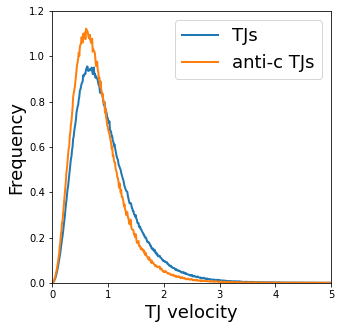

<Figure size 432x288 with 0 Axes>

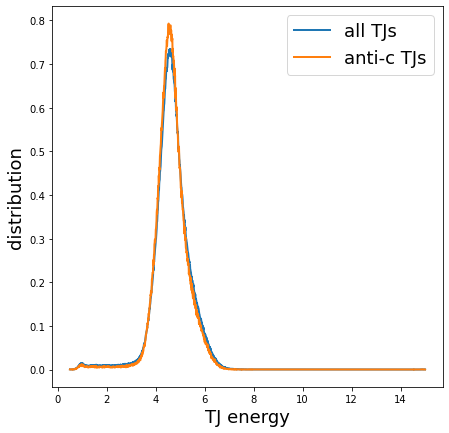

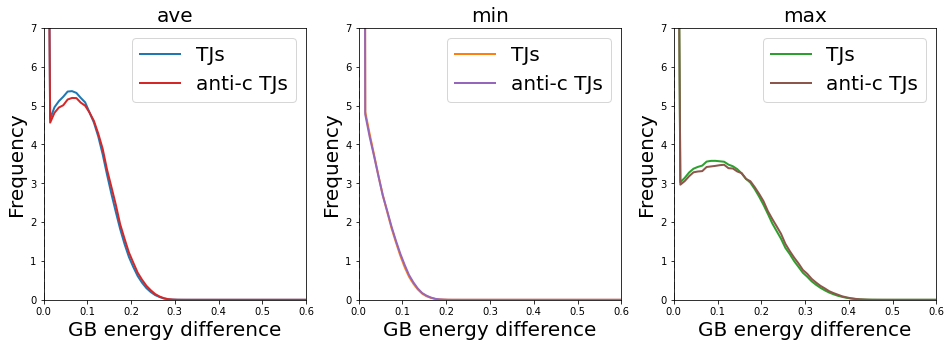

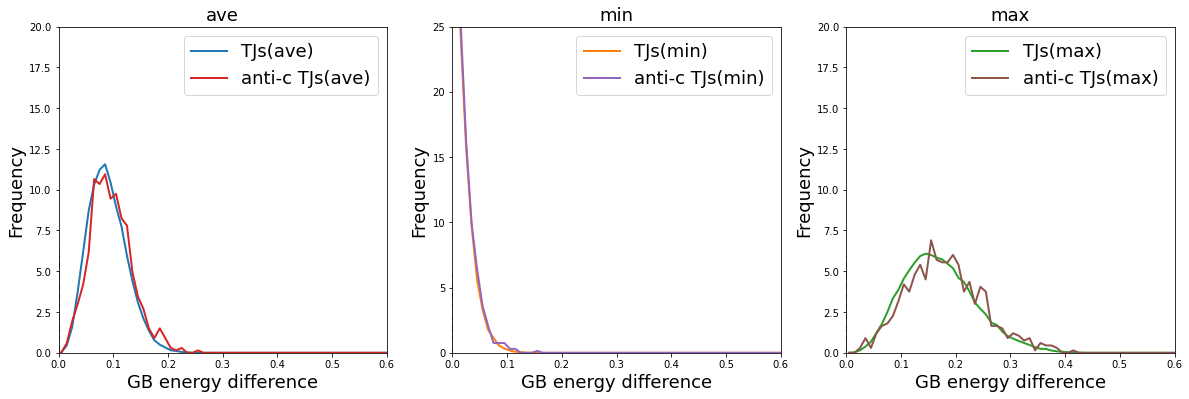

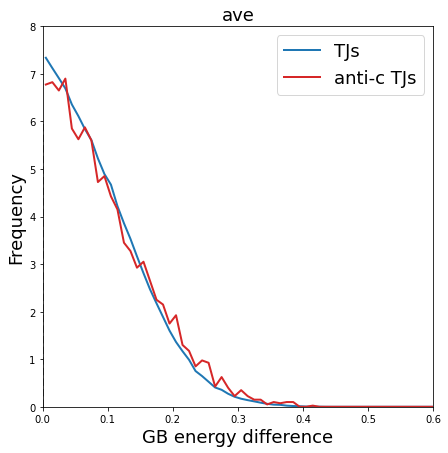

In [43]:

    xLim = [0,1000.1]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    xLim_energy = [0.5,15.0]
    binNum_energy = round((abs(xLim_energy[0])+abs(xLim_energy[1]))/binValue)
    xCor_energy = np.linspace((xLim_energy[0]+binValue/2),(xLim_energy[1]-binValue/2),binNum_energy)
    xLim_GBenergy = [0.0,1.2]
    binNum_GBenergy = round((abs(xLim_GBenergy[0])+abs(xLim_GBenergy[1]))/binValue)
    xCor_GBenergy = np.linspace((xLim_GBenergy[0]+binValue/2),(xLim_GBenergy[1]-binValue/2),binNum_GBenergy)
    xLim_GBDiffenergy = [-0.6,1.0]
    binNum_GBDiffenergy = round((abs(xLim_GBDiffenergy[0])+abs(xLim_GBDiffenergy[1]))/binValue)
    xCor_GBenergy_diff = np.linspace((xLim_GBDiffenergy[0]+binValue/2),(xLim_GBDiffenergy[1]-binValue/2),binNum_GBenergy)
    freqArray_velocity = np.zeros(binNum)
    freqArray_velocity_focus = np.zeros(binNum)
    freqArray_energy = np.zeros(binNum_energy)
    freqArray_energy_focus = np.zeros(binNum_energy)
    freqArray_GBenergy = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four_all = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four_all = np.zeros(binNum_GBenergy)
    
    
    for site_i in range(len(TJ_velocity_1Dlist)):
        velocity = TJ_velocity_1Dlist[site_i]
        freqArray_velocity[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_energy_1Dlist[site_i]
        freqArray_energy[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity = freqArray_velocity/np.sum(freqArray_velocity*binValue)
    freqArray_energy = freqArray_energy/np.sum(freqArray_energy*binValue)
    for site_i in range(len(TJ_focus_velocity_1Dlist)):
        velocity = TJ_focus_velocity_1Dlist[site_i]
        freqArray_velocity_focus[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_focus_energy_1Dlist[site_i]
        freqArray_energy_focus[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity_focus = freqArray_velocity_focus/np.sum(freqArray_velocity_focus*binValue)
    freqArray_energy_focus = freqArray_energy_focus/np.sum(freqArray_energy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist)):
        GBenergy = TJ_GBenergy_1Dlist[site_i]
        freqArray_GBenergy[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy = freqArray_GBenergy/np.sum(freqArray_GBenergy*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist)):
        GBenergy = TJ_focus_GBenergy_1Dlist[site_i]
        freqArray_GBenergy_focus[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus = freqArray_GBenergy_focus/np.sum(freqArray_GBenergy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_three[0] = freqArray_GBenergy_diff_three[0]/np.sum(freqArray_GBenergy_diff_three[0]*binValue)
    freqArray_GBenergy_diff_three[1] = freqArray_GBenergy_diff_three[1]/np.sum(freqArray_GBenergy_diff_three[1]*binValue)
    freqArray_GBenergy_diff_three[2] = freqArray_GBenergy_diff_three[2]/np.sum(freqArray_GBenergy_diff_three[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_focus_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_three[0] = freqArray_GBenergy_focus_diff_three[0]/np.sum(freqArray_GBenergy_focus_diff_three[0]*binValue)
    freqArray_GBenergy_focus_diff_three[1] = freqArray_GBenergy_focus_diff_three[1]/np.sum(freqArray_GBenergy_focus_diff_three[1]*binValue)
    freqArray_GBenergy_focus_diff_three[2] = freqArray_GBenergy_focus_diff_three[2]/np.sum(freqArray_GBenergy_focus_diff_three[2]*binValue)
    # four GB energy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four[0] = freqArray_GBenergy_diff_four[0]/np.sum(freqArray_GBenergy_diff_four[0]*binValue)
    freqArray_GBenergy_diff_four[1] = freqArray_GBenergy_diff_four[1]/np.sum(freqArray_GBenergy_diff_four[1]*binValue)
    freqArray_GBenergy_diff_four[2] = freqArray_GBenergy_diff_four[2]/np.sum(freqArray_GBenergy_diff_four[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_focus_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four[0] = freqArray_GBenergy_focus_diff_four[0]/np.sum(freqArray_GBenergy_focus_diff_four[0]*binValue)
    freqArray_GBenergy_focus_diff_four[1] = freqArray_GBenergy_focus_diff_four[1]/np.sum(freqArray_GBenergy_focus_diff_four[1]*binValue)
    freqArray_GBenergy_focus_diff_four[2] = freqArray_GBenergy_focus_diff_four[2]/np.sum(freqArray_GBenergy_focus_diff_four[2]*binValue)
    # for all four enenrgy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four_all = freqArray_GBenergy_diff_four_all/np.sum(freqArray_GBenergy_diff_four_all*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_focus_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_focus_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four_all = freqArray_GBenergy_focus_diff_four_all/np.sum(freqArray_GBenergy_focus_diff_four_all*binValue)

    
    # plot
    figure_name_TJvelocity = f"figures/3D_TJ_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([0,5])
    plt.ylim([0,1.2])
    plt.plot(xCor, freqArray_velocity,'-', linewidth=2,label='TJs')
    plt.plot(xCor, freqArray_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.savefig(figure_name_TJvelocity, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJenergy = f"figures/3D_TJ_energy_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim([0,0.8])
    # plt.ylim([0,0.05])
    plt.plot(xCor_energy, freqArray_energy,'-', linewidth=2,label='all TJs')
    plt.plot(xCor_energy, freqArray_energy_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_TJenergy, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJ_GBenergy = f"figures/3D_TJ_GBenergy_{case_name}_afterBin.png"
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[0],'-', linewidth=2, label='TJs',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[0],'-', linewidth=2, label='anti-c TJs',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('ave',fontsize=20)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[1],'-', linewidth=2, label='TJs',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[1],'-', linewidth=2, label='anti-c TJs',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('min',fontsize=20)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[2],'-', linewidth=2, label='TJs',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[2],'-', linewidth=2, label='anti-c TJs',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(fontsize=20)
    plt.title('max',fontsize=20)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot focus on four GB energy
    figure_name_TJ_GBenergy = f"figures/3D_TJ_GBenergy_four_{case_name}_afterBin.png"
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[0],'-', linewidth=2, label='TJs(ave)',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[0],'-', linewidth=2, label='anti-c TJs(ave)',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,20])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[1],'-', linewidth=2, label='TJs(min)',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[1],'-', linewidth=2, label='anti-c TJs(min)',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,25])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('min',fontsize=18)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[2],'-', linewidth=2, label='TJs(max)',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[2],'-', linewidth=2, label='anti-c TJs(max)',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,20])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('max',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot all energy difference
    figure_name_TJ_GBenergy = f"figures/3D_TJ_GBenergy_four_all_{case_name}_afterBin.png"
    plt.figure(figsize=(7,7))
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four_all,'-', linewidth=2, label='TJs',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four_all,'-', linewidth=2, label='anti-c TJs',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    


In [44]:
    # extract TJ average velocity 
    time_interval = 2
    edge_matrix = np.array([[0,0,0],[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0]])
    edge_matrix = np.array([[0,0,0],[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[0,0,size_z],[0,0,-size_z],
                            [size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0],
                            [size_x,size_y,size_z],[-size_x,-size_y,size_z],[-size_x,size_y,size_z],[size_x,-size_y,size_z],
                            [size_x,size_y,-size_z],[-size_x,-size_y,-size_z],[-size_x,size_y,-size_z],[size_x,-size_y,-size_z]])
    
    init_TJ_keys = dict()
    mean_velocity_TJs = dict()
    for TJ_key in TJ_information_dict_list[0]: init_TJ_keys[TJ_key] = 0 # add all TJs in 0 step as init
    for time_step in range(1, step_num):
        
        for TJ_key in TJ_information_dict_list[time_step]:
            if TJ_key in init_TJ_keys: # know the init step
                if time_step==step_num-1 or TJ_key not in TJ_information_dict_list[time_step+1]: # last step for current TJs
                    # calculate velocity and keep it
                    init_step = init_TJ_keys[TJ_key]
                    location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                    location_end_step = TJ_information_dict_list[time_step][TJ_key][:3]
                    difference_9points = np.tile(location_end_step,(19,1)) + edge_matrix - np.tile(location_init_step,(19,1))
                    distance_9points = np.linalg.norm(difference_9points,axis=1)
                    distance = np.min(distance_9points)
                    # calculate velocity
                    mean_velocity = distance / (time_interval*(time_step-init_step))
                    mean_velocity_TJs[TJ_key] = mean_velocity
            else: # don't know the init step
                init_TJ_keys[TJ_key] = time_step
    TJ_mean_velocity_1Dlist = list(mean_velocity_TJs.values())
    
    mean_velocity_focus_TJs = dict()
    for GB_key in tqdm(GB_id_focus_detail):
        if len(GB_id_focus_detail[GB_key]) < 2: continue
        init_step = GB_id_focus_detail[GB_key][0]
        end_step = GB_id_focus_detail[GB_key][-1]
        pair_id_pair_focus = GB_infomation_dict_list[init_step][GB_key][6:8]
        
        for TJ_key in TJ_information_dict_list[init_step]:
            if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                if TJ_key not in TJ_information_dict_list[end_step]: continue
                
                location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
                difference_9points = np.tile(location_end_step,(19,1)) + edge_matrix - np.tile(location_init_step,(19,1))
                distance_9points = np.linalg.norm(difference_9points,axis=1)
                distance = np.min(distance_9points)
                # calculate velocity
                mean_velocity = distance / (time_interval*(end_step-init_step))
                mean_velocity_focus_TJs[TJ_key] = mean_velocity
                
        
        # location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
        # location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
        # difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
        # distance_9points = np.linalg.norm(difference_9points,axis=1)
        # distance = np.min(distance_9points)
        # # calculate velocity
        # mean_velocity = distance / (time_interval*(time_step-init_step))
        # mean_velocity_focus_TJs[TJ_key] = mean_velocity
    TJ_focus_mean_velocity_1Dlist = list(mean_velocity_focus_TJs.values())
    
    

100%|██████████| 47594/47594 [41:49<00:00, 18.97it/s] 


<Figure size 432x288 with 0 Axes>

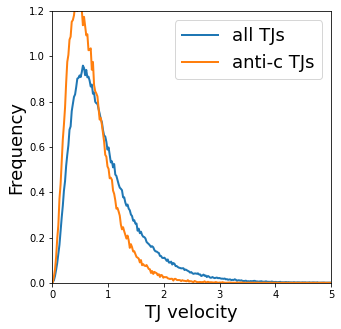

In [45]:

    
    xLim = [0,1000]
    binValue = 0.02001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_mean_velocity = np.zeros(binNum)
    freqArray_mean_velocity_focus = np.zeros(binNum)
    
    for site_i in range(len(TJ_mean_velocity_1Dlist)):
        mean_velocity = TJ_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity = freqArray_mean_velocity/np.sum(freqArray_mean_velocity*binValue)
    for site_i in range(len(TJ_focus_mean_velocity_1Dlist)):
        mean_velocity = TJ_focus_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity_focus[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity_focus = freqArray_mean_velocity_focus/np.sum(freqArray_mean_velocity_focus*binValue)
    
    # plot
    figure_name_TJmeanvelocity = f"figures/3D_TJ_mean_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.xlim([0,5])
    plt.ylim([0,1.2])
    plt.plot(xCor, freqArray_mean_velocity,'-', linewidth=2,label='all TJs')
    plt.plot(xCor, freqArray_mean_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.savefig(figure_name_TJmeanvelocity, dpi=400,bbox_inches='tight')
    

        

In [36]:
mean_velocity

223.66744286998946